In [1]:
pacman::p_load(ggplot2,dplyr,tidyr,data.table,stats,
               vegan,ggpubr,corrplot,Hmisc,GGally,
               igraph,network, sna, wesanderson,dils,
               RColorBrewer,data.table,dtplyr,cowplot,tibble,
               ggforce,ggnewscale,philentropy,ggdendro)

In [2]:
devtools::install_github("briatte/ggnet")
library(ggnet)

Skipping install of 'ggnet' from a github remote, the SHA1 (da9a7cf2) has not changed since last install.
  Use `force = TRUE` to force installation


Attaching package: ‘ggnet’


The following objects are masked from ‘package:GGally’:

    ggnet, ggnet2




Read and format taxonomy information from `EUKulele` and `mmseqs`.

In [3]:
eukaryotic_taxonomy = data.frame(fread(file.path("..","data",
                                                 "2021-marzoanmmetsp-estimated-taxonomy.csv"))) %>%
            dplyr::filter(taxonomy != '-;-;-;-;-;-') %>% separate(taxonomy, sep = ";",
                                     c("Domain","Supergroup","Phylum","Class",
                                       "Order","Family","Genus","Species")) %>%
            dplyr::mutate_all(as.character) %>%
            dplyr::mutate(mag = trimws(mag))
prokaryotic_taxonomy = data.frame(fread(file.path("..","data","prokaryote_taxonomy.csv")))%>% 
                        tidyr::separate(classification,sep=";",
                                        c("Domain","Phylum","Class",
                                          "Order","Family","Genus",
                                          "Species"))
mmseqs_tax = read.csv(file.path("..","data","mmseqs-taxonomy.tsv"),
                         sep='\t', row.names=1) %>%
    dplyr::rename(c("Clade"="clade","Kingdom"="kingdom","Phylum"="phylum",
                    "Class"="class","Order"="order","Family"="family",
                    "Genus"="genus","Species"="species"))
mmseqs_tax$Genome = rownames(mmseqs_tax)
row.names(mmseqs_tax) <- NULL 
mmseqs_tax = mmseqs_tax %>% dplyr::mutate_all(as.character) %>%
    dplyr::mutate(Genome = trimws(Genome))
full_taxonomy = mmseqs_tax %>% dplyr::left_join(eukaryotic_taxonomy,by=c("Genome"="mag")) %>%
    dplyr::mutate(Phylum = case_when(Phylum.x == Phylum.y ~ Phylum.x,
                                     ((Phylum.x == "-")  | (Phylum.x == ".") | (is.na(Phylum.x))) ~ Phylum.y,
                                     ((Phylum.y == "-")  | (Phylum.y == ".") | (is.na(Phylum.y))) ~ Phylum.x,
                                     TRUE ~ Phylum.x),
                  Class = case_when(Class.x == Class.y ~ Class.x,
                             ((Class.x == "-") | (Class.x == ".") | (is.na(Class.x))) ~ Class.y,
                             ((Class.y == "-") | (Class.y == ".") | (is.na(Class.y))) ~ Class.x,
                             TRUE ~ Class.x),
                  Order = case_when(Order.x == Order.y ~ Order.x,
                             ((Order.x == "-")  | (Order.x == ".") | (is.na(Order.x))) ~ Order.y,
                             ((Order.y == "-")  | (Order.y == ".") | (is.na(Order.y))) ~ Order.x,
                             TRUE ~ Order.x),
                  Family = case_when(Family.x == Family.y ~ Family.x,
                             ((Family.x == "-")  | (Family.x == ".") | (is.na(Family.x))) ~ Family.y,
                             ((Family.y == "-")  | (Family.y == ".") | (is.na(Family.y))) ~ Family.x,
                             TRUE ~ Family.x),
                  Genus = case_when(Genus.x == Genus.x ~ Genus.x,
                             (Genus.x == "-")  | (Genus.x == ".") | (is.na(Genus.x)) ~ Genus.y,
                             (Genus.y == "-")  | (Genus.x == ".") | (is.na(Genus.y)) ~ Genus.x,
                             TRUE ~ Genus.x),
                  Species = case_when(Species.x == Species.y ~ Species.x,
                             (Species.x == "-")  | (Species.x == ".") | (is.na(Species.x)) ~ Species.y,
                             (Species.y == "-")  | (Species.y == ".") | (is.na(Species.y)) ~ Species.x,
                             TRUE ~ Species.x)) %>%
    dplyr::select(-c(Phylum.x,Phylum.y,Class.x,Class.y,Order.x,Order.y,Family.x,Family.y,Genus.x,
                    Genus.y,Species.x,Species.y)) %>%
    dplyr::full_join(prokaryotic_taxonomy,by=c("Genome","Domain","Phylum","Class",
                                               "Order","Family","Genus","Species")) %>%
    dplyr::distinct(Genome,.keep_all=T)

#' Copy the taxonomy and return whether a eukaryote or a prokaryote
#' and its taxonomy string.
# Author: Arianna Krinos ----------------
get_euk_prok <- function(genome_names) {
    modified_df = data.frame(Genome = genome_names) %>% 
        dplyr::left_join(full_taxonomy, by = c("Genome")) %>%
        dplyr::mutate(EukOrProk = as.character(Domain)) %>%
        dplyr::mutate(EukOrProk = case_when(EukOrProk == "Eukaryota" ~ "euk",
                                            EukOrProk == "d__Bacteria" ~ "prok",
                                            TRUE ~ "unclass"))
    return(modified_df)
}


#' Copy the taxonomy and return whether a eukaryote or a prokaryote
#' and its taxonomy string.
# Author: Arianna Krinos ----------------
get_tax_string <- function(genome_names,cluster_groups=cluster_groups) {
    modified_df = data.frame(Genome = genome_names) %>% 
        dplyr::left_join(cluster_groups %>%
                         dplyr::distinct(Cluster, .keep_all = T),by=c("Genome"="Cluster")) %>%
        dplyr::mutate(Genome = case_when(is.na(Genome)|(grepl("Cluster",Genome)) ~ MAG,
                                          TRUE ~ Genome)) %>%
        dplyr::left_join(full_taxonomy, by = c("Genome")) %>%
        dplyr::mutate(EukOrProk = as.character(Domain)) %>%
        dplyr::mutate(EukOrProk = case_when(EukOrProk == "Eukaryota" ~ "euk",
                                            EukOrProk == "d__Bacteria" ~ "prok",
                                            TRUE ~ "unclass"))
    tax_cols = c("Domain","Clade","Kingdom","Supergroup","Phylum","Class",
                 "Order","Family","Genus","Species")
    modified_df = modified_df %>% unite("tax_combo", all_of(tax_cols), sep=";",remove = TRUE)
    return(modified_df$tax_combo)
}

#' Combine the cluster names and sort them so that we don't have duplicates based on cluster
#' member ordering.
#' Author: Arianna Krinos -----------------
get_combo <- function(df_graph) { 
    combined_clust = c()
    for (i in c(1:length(df_graph$from))) {
        combined_clust = c(combined_clust,paste(sort(c(df_graph$from[i],df_graph$to[i])),collapse="_"))
    }
    return(combined_clust)
}

Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 650 rows [2, 6, 11, 17, 18, 22, 39, 51, 53, 86, 92, 103, 111, 122, 123, 124, 131, 133, 137, 138, ...].”


Read in the correlations calculated in the Python script `networkanalysis.py` in the present folder and stored in the `data` folder (but not on GH as they are too large).

In [4]:
# We chose to use the TPM-derived correlations.
combined_graph_tpm = data.frame(fread(file.path("..","data","combined_graph_tpm_fullpval.csv")))
combined_graph_tpm = combined_graph_tpm[combined_graph_tpm$pval < (1-(1-0.05)**(1/nrow(combined_graph_tpm))),]

RUN IF YOU DON'T HAVE A COPY OF "igraph_dataframe.csv"

In [5]:
for_igraph = combined_graph_tpm[,colnames(combined_graph_tpm) %in% c("mag1","mag2","corrcoef")]
for_igraph$Link = ""
modified_df = data.frame(Genome = for_igraph$mag1) %>% 
        dplyr::left_join(full_taxonomy %>% dplyr::distinct(Genome,.keep_all=TRUE), by = c("Genome")) %>%
        dplyr::mutate(EukOrProk = as.character(Domain)) %>%
        dplyr::mutate(EukOrProk = case_when(EukOrProk == "Eukaryota" ~ "euk",
                                            EukOrProk == "d__Bacteria" ~ "prok",
                                            TRUE ~ "unclass"))
modified_df2 = data.frame(Genome = for_igraph$mag2) %>% 
        dplyr::left_join(full_taxonomy %>% dplyr::distinct(Genome,.keep_all=TRUE), by = c("Genome")) %>%
        dplyr::mutate(EukOrProk = as.character(Domain)) %>%
        dplyr::mutate(EukOrProk = case_when(EukOrProk == "Eukaryota" ~ "euk",
                                            EukOrProk == "d__Bacteria" ~ "prok",
                                            TRUE ~ "unclass"))

for_igraph = for_igraph %>%
    dplyr::mutate(Dom1=as.character(modified_df$EukOrProk),
                  Dom2=as.character(modified_df2$EukOrProk))

for_igraph = for_igraph %>% dplyr::mutate(Link = case_when((Dom1 == "prok") & (Dom2 == "euk") ~ "Euk-Prok",
                                               (Dom2 == "prok") & (Dom1 == "euk") ~ "Euk-Prok",
                                               (Dom1 == "prok") & (Dom2 == "prok") ~ "Prok-Prok",
                                               (Dom1 == "euk") & (Dom2 == "euk") ~ "Euk-Euk",
                                               TRUE ~ "Other"))
write.csv(for_igraph,"igraph_dataframe.csv")

RUN EACH TIME

In [6]:
for_igraph = read.csv("igraph_dataframe.csv")

In [7]:
##### FILTER CANDIDATES BASED ON BUSCO COMPLETENESS #####
busco_completeness = data.frame(fread(file.path("..","data","EUK_BUSCO_CC.csv")))
for_igraph_buscofilt = for_igraph %>% dplyr::left_join(busco_completeness, by = c("mag1" = "V1")) %>%
    dplyr::left_join(busco_completeness, by = c("mag2" = "V1")) %>%
    dplyr::filter((Completeness.x > 30) | (is.na(Completeness.x))) %>%
    dplyr::filter((Completeness.y > 30) | (is.na(Completeness.y)))

First, we'll reduce the total number of MAGs according to those that have >95% pairwise ANI score plus a high degree of correlation with one another, targeting the upper right corner of the ANI graph in the supplement. Next, we cut out the links in the network between eukaryotes that are of a substantially high ANI score + have a pairwise score that's high. We'll set the pairwise score as >95% and the correlation score as >0.7.

In [8]:
##### REFACTOR BY HIGHLY SELF-SIMILAR MAGS PER ANI #####
tara_ani = read.csv(file.path("..","data","all-alex-v-alex.fastani.out"), sep = "\t", header = FALSE)
colnames(tara_ani) = c("i","j","pairwisescore","col4","col5")

tara_ani$i = as.character(tara_ani$i)
tara_ani$j = as.character(tara_ani$j)
cc       <- strsplit(tara_ani$i,'\\.')
part1    <- unlist(cc)[2*(1:length(tara_ani$i))-1]

tara_ani$i = part1
cc       <- strsplit(tara_ani$j,'\\.')
part1    <- unlist(cc)[2*(1:length(tara_ani$j))-1]
tara_ani$j = part1

cc       <- strsplit(tara_ani$i,'/')
part1    <- unlist(cc)
tara_ani$i  <- as.character(filter(data.frame("Part1" = part1), grepl(paste("_bin", collapse="|"), Part1))[,1])

cc       <- strsplit(tara_ani$j,'/')
part1    <- unlist(cc)
tara_ani$j  <- as.character(filter(data.frame("Part1" = part1), grepl(paste("_bin", collapse="|"), Part1))[,1])

edge_by_ani = for_igraph_buscofilt %>% dplyr::filter(Link == "Euk-Euk") %>% 
    dplyr::left_join(tara_ani, by = c("mag1" = "i", "mag2" = "j"))

for_igraph_buscofilt_all = for_igraph_buscofilt %>%
    dplyr::rename(c("from"="mag1","to"="mag2"))

for_igraph_buscofilt = for_igraph_buscofilt %>% dplyr::filter((Link == "Euk-Prok") | (Link == "Euk-Euk")) %>%
    dplyr::rename(c("from"="mag1","to"="mag2"))


##### Find the links that fit these criteria per ANI and create an alias for these closely-related MAGs. #####
cluster_groups = data.frame("MAG"=c(""), "Cluster"=c(0))
cluster_counter = 1
meet_criteria = edge_by_ani %>% dplyr::filter((pairwisescore > 95) & (corrcoef > 0.504))
meet_criteria = meet_criteria %>% dplyr::rename(c("from"="mag1","to"="mag2"))
for (curr in unique(meet_criteria$to)) {
    from_mags = (meet_criteria %>% dplyr::filter(to == curr))$from
    existing_clusters = (cluster_groups %>% dplyr::filter(MAG %in% from_mags))$Cluster
    if (length(existing_clusters) > 0) {
        curr_cluster = min(existing_clusters)
    } else {
        curr_cluster = cluster_counter
        cluster_counter = cluster_counter + 1
    }
    new_clusters = data.frame("MAG" = c(curr,from_mags), 
                              "Cluster" = rep(as.numeric(curr_cluster),length(from_mags) + 1))
    cluster_groups = cluster_groups %>% dplyr::bind_rows(new_clusters)
    cluster_groups$Cluster[cluster_groups$Cluster %in% existing_clusters] = curr_cluster
}
cluster_groups = cluster_groups %>% distinct(Cluster, MAG, .keep_all = TRUE) %>% dplyr::filter(MAG != "")
cluster_groups$MAG = as.character(cluster_groups$MAG)
cluster_groups$Cluster = paste0("Cluster_",cluster_groups$Cluster)
cluster_groups$classification = get_tax_string(cluster_groups$MAG,cluster_groups)

reclustered_network = for_igraph_buscofilt %>% 
    dplyr::mutate("Classifications_from" = get_tax_string(for_igraph_buscofilt$from,cluster_groups)) %>%
    dplyr::mutate("Classifications_to" = get_tax_string(for_igraph_buscofilt$to,cluster_groups)) %>%
    separate(Classifications_to, sep = ";", fill = "left",
                    paste0(c("Domain","Clade","Kingdom","Supergroup","Phylum","Class",
                 "Order","Family","Genus","Species"),"_to")) %>%
    separate(Classifications_from, sep = ";", fill = "left",
                    paste0(c("Domain","Clade","Kingdom","Supergroup","Phylum","Class",
                 "Order","Family","Genus","Species"),"_from")) %>%
    dplyr::left_join(cluster_groups, by=c("from"="MAG")) %>%
    dplyr::rename(c("Cluster_From" = "Cluster")) %>%
    dplyr::left_join(cluster_groups, by=c("to"="MAG")) %>%
    dplyr::rename(c("Cluster_To" = "Cluster")) %>%  
    dplyr::mutate(from = case_when(grepl("Cluster", Cluster_From) ~ Cluster_From,
                                   TRUE ~ from)) %>%
    dplyr::mutate(to = case_when(grepl("Cluster", Cluster_To) ~ Cluster_To,
                                   TRUE ~ to)) %>%
    dplyr::filter(corrcoef > 0.5) %>%
    dplyr::filter(from != to) 
reclustered_network$Domain_to[is.na(reclustered_network$Domain_to)] = "Bacteria"
reclustered_network$Domain_from[is.na(reclustered_network$Domain_from)] = "Bacteria"

reclustered_network_allconnections = for_igraph_buscofilt_all %>% 
    dplyr::mutate("Classifications_from" = get_tax_string(for_igraph_buscofilt_all$from,cluster_groups)) %>%
    dplyr::mutate("Classifications_to" = get_tax_string(for_igraph_buscofilt_all$to,cluster_groups)) %>%
    separate(Classifications_to, sep = ";", fill = "left",
                    paste0(c("Domain","Clade","Kingdom","Supergroup","Phylum","Class",
                 "Order","Family","Genus","Species"),"_to")) %>%
    separate(Classifications_from, sep = ";", fill = "left",
                    paste0(c("Domain","Clade","Kingdom","Supergroup","Phylum","Class",
                 "Order","Family","Genus","Species"),"_from")) %>%
    dplyr::left_join(cluster_groups, by=c("from"="MAG")) %>%
    dplyr::rename(c("Cluster_From" = "Cluster")) %>%
    dplyr::left_join(cluster_groups, by=c("to"="MAG")) %>%
    dplyr::rename(c("Cluster_To" = "Cluster")) %>%  
    dplyr::mutate(from = case_when(grepl("Cluster", Cluster_From) ~ Cluster_From,
                                   TRUE ~ from)) %>%
    dplyr::mutate(to = case_when(grepl("Cluster", Cluster_To) ~ Cluster_To,
                                   TRUE ~ to)) %>%
    dplyr::filter(from != to) 
reclustered_network_allconnections$Domain_to[is.na(reclustered_network_allconnections$Domain_to)] = "Bacteria"
reclustered_network_allconnections$Domain_from[is.na(reclustered_network_allconnections$Domain_from)] = "Bacteria"

In [10]:
write.csv(reclustered_network_allconnections,file.path("..","data","reclustered_net_all.csv"))
write.csv(reclustered_network_allconnections,file.path("..","data","reclustered_net_all.csv"))

In [ ]:
reclustered_network_allconnections = data.frame(fread(file.path("..","data","reclustered_net_all.csv")))

SUPPLEMENTARY FIGURES : ANI clustering justification

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


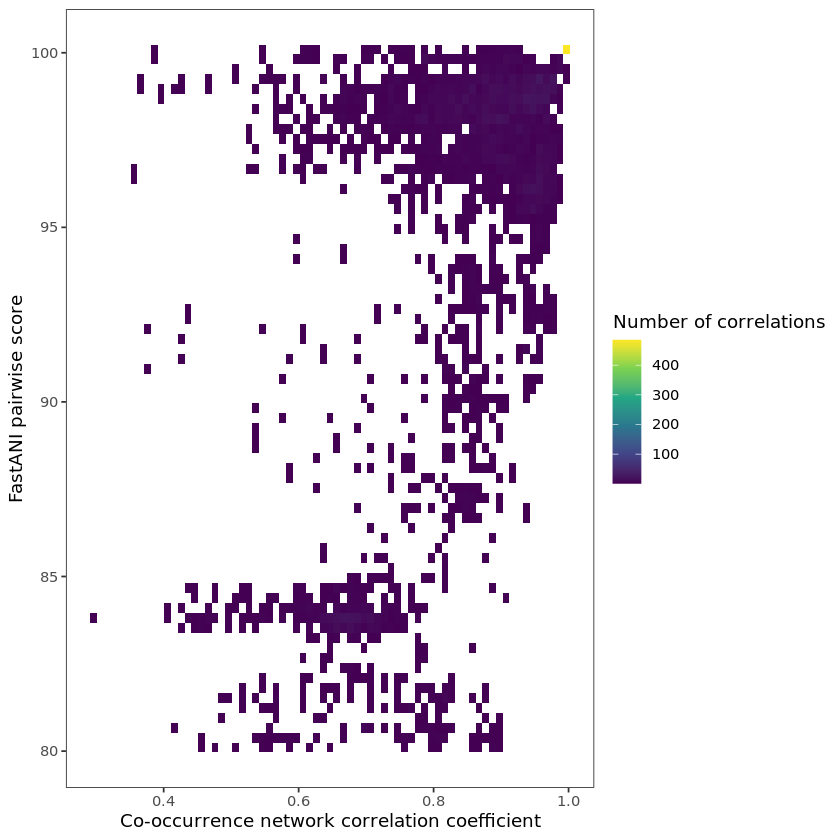

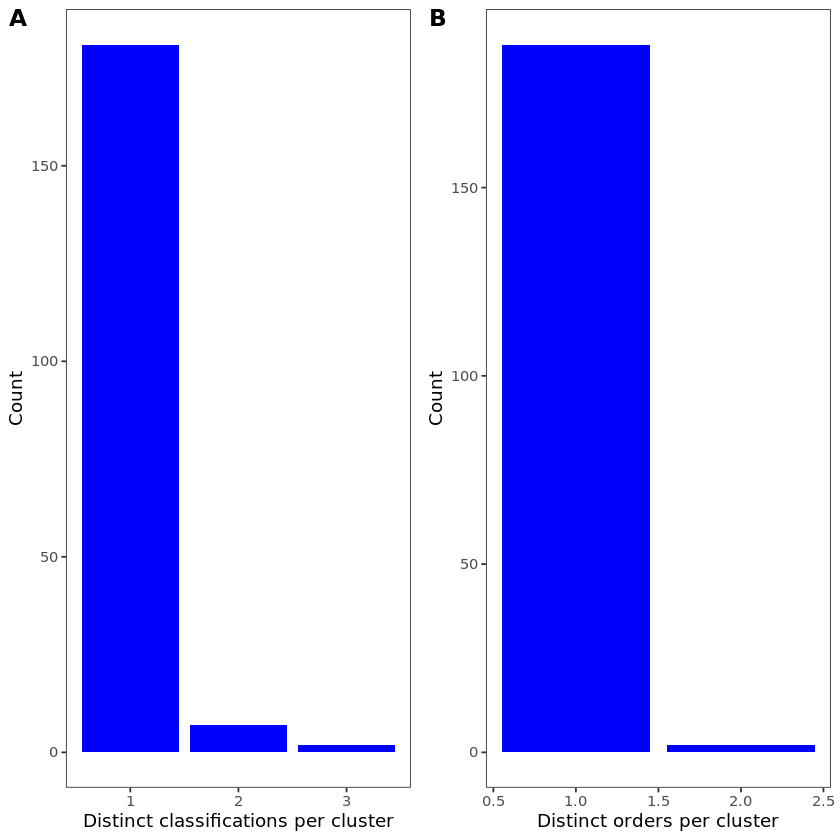

In [11]:
##### CREATE ANI FIGURE #####
ani_plot = ggplot(edge_by_ani %>% dplyr::filter(pairwisescore > 80)) +
    geom_bin2d(aes(x = corrcoef, y = pairwisescore), bins = 70) +
    scale_fill_continuous(type = "viridis", name = "Number of correlations") +
    theme_test() + 
    xlab("Co-occurrence network correlation coefficient") +
    ylab("FastANI pairwise score")
ggsave(plot=ani_plot, file.path("ani_justification.png"), 
       dpi=300, width = 6, height = 4, units = "in")
ani_plot

##### CREATE FIGURE TO JUSTIFY THAT CLUSTERS ARE SIMILAR IN TERMS OF TAX COMPOSITION #####
distinct_classifications = cluster_groups %>% distinct(Cluster, classification, .keep_all = TRUE) %>% 
                            separate(classification, sep = ";",
                                     c("Domain","Clade","Kingdom","Supergroup","Phylum","Class",
                 "Order","Family","Genus","Species"))
distinct_orders = cluster_groups %>% distinct(Cluster, classification, .keep_all = TRUE) %>% 
                            separate(classification, sep = ";",
                                     c("Domain","Clade","Kingdom","Supergroup","Phylum","Class",
                 "Order","Family","Genus","Species")) %>%
                  distinct(Cluster, Order, .keep_all = TRUE)

distinct_classes = ggplot(distinct_classifications %>% 
                          dplyr::group_by(Cluster) %>% dplyr::summarize(Count = n())) +
    geom_histogram(aes(x=Count),fill="blue",stat="count") + theme_test() + ylab("Count") +
    xlab("Distinct classifications per cluster")

distinct_orders = ggplot(distinct_orders %>% dplyr::group_by(Cluster) %>% 
                         dplyr::summarize(Count = n())) +
    geom_histogram(aes(x=Count),fill="blue",stat="count") + theme_test() + ylab("Count") +
    xlab("Distinct orders per cluster")

distinct_classifications = cowplot::plot_grid(distinct_classes,distinct_orders,labels=c("A","B"))
ggsave(plot=distinct_classifications,
       file.path("..","si-figures","clustering_justification.png"),
       dpi=300, width = 6, height = 3, units = "in")
distinct_classifications

Now let's generate our actual network figures!

In [12]:
df_graph <- reclustered_network %>% 
            dplyr::select(to,from,corrcoef,Link,Dom1,Dom2)%>%
            dplyr::filter(corrcoef > 0.7)
refactored_graph <- graph_from_data_frame(df_graph,
                                          directed = FALSE, vertices = NULL)

corr_communities <- cluster_louvain(refactored_graph,weight=df_graph$corrcoef)

set_vertex_attr(refactored_graph, "clustermembership",
                index = V(refactored_graph),
                membership(corr_communities))
set_vertex_attr(refactored_graph, "classification",
                index = V(refactored_graph),
                get_tax_string(V(refactored_graph)$name,cluster_groups))

layout_gr <- get.data.frame(refactored_graph) 

IGRAPH 820e51f UN-- 379 16518 -- 
+ attr: name (v/c), clustermembership (v/n), corrcoef (e/n), Link
| (e/c), Dom1 (e/c), Dom2 (e/c)
+ edges from 820e51f (vertex names):
 [1] Cluster_3                  --Cluster_1
 [2] Cluster_10                 --Cluster_1
 [3] Cluster_18                 --Cluster_1
 [4] Cluster_10                 --Cluster_1
 [5] Cluster_31                 --Cluster_1
 [6] Cluster_47                 --Cluster_1
 [7] Cluster_47                 --Cluster_1
+ ... omitted several edges

IGRAPH 820e51f UN-- 379 16518 -- 
+ attr: name (v/c), classification (v/c), corrcoef (e/n), Link (e/c),
| Dom1 (e/c), Dom2 (e/c)
+ edges from 820e51f (vertex names):
 [1] Cluster_3                  --Cluster_1
 [2] Cluster_10                 --Cluster_1
 [3] Cluster_18                 --Cluster_1
 [4] Cluster_10                 --Cluster_1
 [5] Cluster_31                 --Cluster_1
 [6] Cluster_47                 --Cluster_1
 [7] Cluster_47                 --Cluster_1
+ ... omitted several edges

IGRAPH ac334e0 UN-- 379 2816 -- 
+ attr: name (v/c), clustermembership (v/n), corrcoef (e/n), Link
| (e/c), Dom1 (e/c), Dom2 (e/c), combined_clust (e/c)
+ edges from ac334e0 (vertex names):
 [1] Cluster_118--Cluster_47  Cluster_148--Cluster_90  Cluster_118--Cluster_187
 [4] Cluster_187--Cluster_47  Cluster_41 --Cluster_7   Cluster_169--Cluster_18 
 [7] Cluster_169--Cluster_139 Cluster_112--Cluster_88  Cluster_66 --Cluster_98 
[10] Cluster_126--Cluster_87  Cluster_139--Cluster_18  Cluster_160--Cluster_137
[13] Cluster_180--Cluster_8   Cluster_34 --Cluster_9   Cluster_146--Cluster_110
[16] Cluster_135--Cluster_93  Cluster_66 --Cluster_72  Cluster_153--Cluster_90 
[19] Cluster_72 --Cluster_102 Cluster_72 --Cluster_54  Cluster_102--Cluster_82 
+ ... omitted several edges

IGRAPH ac334e0 UN-- 379 2816 -- 
+ attr: name (v/c), classification (v/c), corrcoef (e/n), Link (e/c),
| Dom1 (e/c), Dom2 (e/c), combined_clust (e/c)
+ edges from ac334e0 (vertex names):
 [1] Cluster_118--Cluster_47  Cluster_148--Cluster_90  Cluster_118--Cluster_187
 [4] Cluster_187--Cluster_47  Cluster_41 --Cluster_7   Cluster_169--Cluster_18 
 [7] Cluster_169--Cluster_139 Cluster_112--Cluster_88  Cluster_66 --Cluster_98 
[10] Cluster_126--Cluster_87  Cluster_139--Cluster_18  Cluster_160--Cluster_137
[13] Cluster_180--Cluster_8   Cluster_34 --Cluster_9   Cluster_146--Cluster_110
[16] Cluster_135--Cluster_93  Cluster_66 --Cluster_72  Cluster_153--Cluster_90 
[19] Cluster_72 --Cluster_102 Cluster_72 --Cluster_54  Cluster_102--Cluster_82 
+ ... omitted several edges

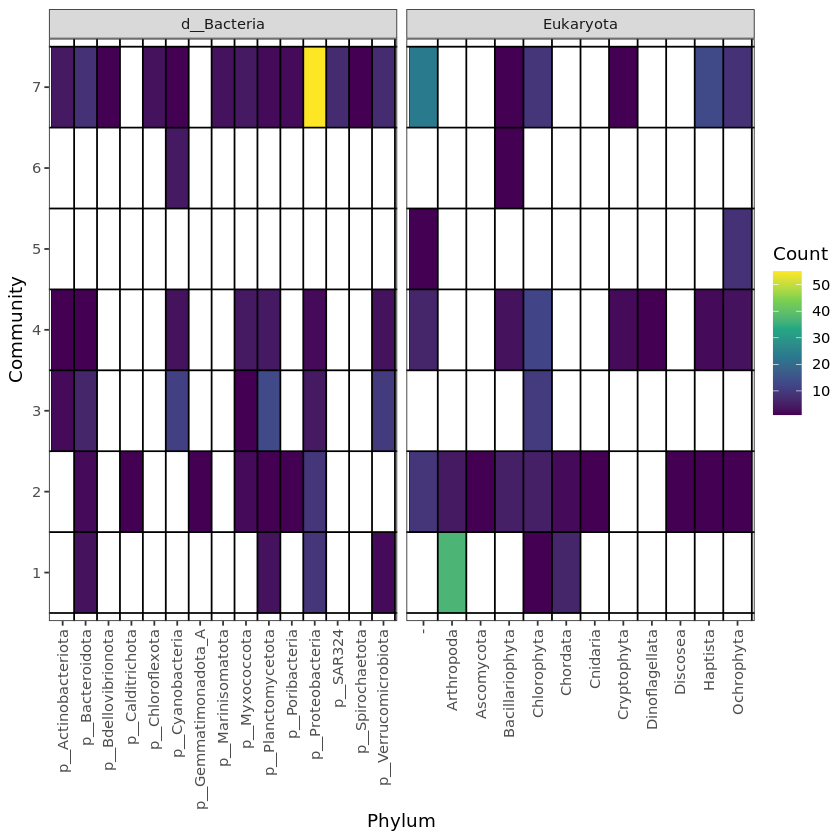

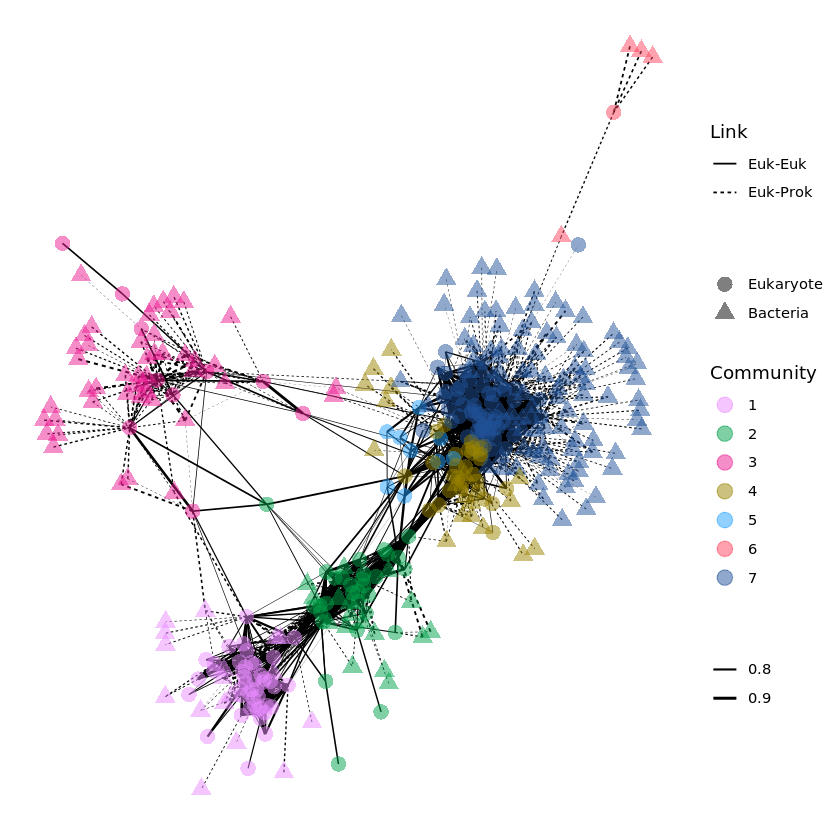

In [13]:
##### GENERATE GRAPH FROM THE REFACTORED NETWORK #####
df_graph <- reclustered_network %>% 
            dplyr::select(to,from,corrcoef,Link,Dom1,Dom2)%>%
            dplyr::filter(corrcoef > 0.7) %>%
            arrange(desc(corrcoef)) %>%
            dplyr::distinct(to,from,Link,Dom1,Dom2,.keep_all=TRUE)
df_graph$combined_clust = get_combo(df_graph)
df_graph <- df_graph %>% dplyr::distinct(combined_clust,.keep_all=TRUE)
refactored_graph <- graph_from_data_frame(df_graph,
                                          directed = FALSE, vertices = NULL)

corr_communities <- cluster_louvain(refactored_graph,weight=df_graph$corrcoef)

set_vertex_attr(refactored_graph, "clustermembership",
                index = V(refactored_graph),
                membership(corr_communities))
set_vertex_attr(refactored_graph, "classification",
                index = V(refactored_graph),
                get_tax_string(V(refactored_graph)$name,cluster_groups))

edge_df <- df_graph

# Create a layout of the graph
layout_gr <- as.data.frame(layout.fruchterman.reingold(refactored_graph))
# Add the MAG labels
layout_gr$mag <- V(refactored_graph)$name

# Add the euk-prok labels
edge_df_inform <- edge_df %>% dplyr::select(from,Dom1) %>% dplyr::rename(c("mag"="from","class"="Dom1")) %>%
                    dplyr::bind_rows(edge_df %>% dplyr::select(to,Dom2) %>% 
                                     dplyr::rename(c("mag"="to","class"="Dom2")))
layout_gr$eukprok <- edge_df_inform$class[match(layout_gr$mag,edge_df_inform$mag)]
layout_gr$classification <- get_tax_string(layout_gr$mag,cluster_groups)
layout_gr$community <- membership(corr_communities)

layout_gr <- layout_gr %>% 
                    dplyr::mutate("degree" = as.numeric(as.character(igraph::degree(refactored_graph,
                                                                                  v = layout_gr$mag))))

layout_gr = layout_gr %>% dplyr::left_join(cluster_groups,by=c("mag"="Cluster")) %>% 
            dplyr::mutate(classification = case_when((classification.x == "none") ~ classification.y,
                                                     TRUE ~ classification.x)) %>%
            dplyr::select(V1,V2,eukprok,mag,classification,community,degree)
layout_gr <- layout_gr %>% dplyr::distinct()

edge_df$from.x <- layout_gr$V1[match(edge_df$from, layout_gr$mag)]  #  match the from locations from the node data.frame we previously connected
edge_df$from.y <- layout_gr$V2[match(edge_df$from, layout_gr$mag)]
edge_df$to.x <- layout_gr$V1[match(edge_df$to, layout_gr$mag)]  #  match the to locations from the node data.frame we previously connected
edge_df$to.y <- layout_gr$V2[match(edge_df$to, layout_gr$mag)]

layout_gr_classes = layout_gr %>% 
    separate(classification, sep = ";", fill = "left",
                    c("Domain","Clade","Kingdom","Supergroup",
                      "Phylum","Class","Order","Family","Genus","Species"))

##### VISUALIZE TAXONOMIC CLASSES IN EACH COMMUNITY #####
ggplot(layout_gr_classes) + stat_bin2d(aes(x = Phylum, y = factor(community), fill = after_stat(count)),
                                       colour="black") + 
    facet_wrap(~Domain,scales="free_x") + theme_test() + 
    scale_fill_continuous(na.value = "white", type="viridis", name = "Count") + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    geom_vline(xintercept=seq(1.5, length(unique(layout_gr_classes$Phylum))-0.5, 1), 
             lwd=0.5, colour="black") + 
    geom_hline(yintercept=seq(0.5, length(unique(layout_gr_classes$community))+0.5, 1), 
             lwd=0.5, colour="black") + 
    ylab("Community") + xlab("Phylum")
ggsave(file.path("..","si-figures","network_70cutoff_phylum.png"),
       dpi=300, width = 6, height = 4, units = "in")

##### PLOT THE NETWORK COMMUNITIES #####
# this is adapted from here https://chrischizinski.github.io/rstats/igraph-ggplotll/
# Plot out the initial layout
n <- length(corr_communities)
palette <- c("#ea8cff","#01a24b","#ec1d92","#998400","#27a3ff",
             "#ff455e","#205297","#ffa56d","#764164","#b5706d")

network_plot = ggplot() +
    geom_segment(data=edge_df,aes(x=from.x,xend = to.x,y=from.y,
                                  yend = to.y,size=corrcoef,lty=Link),colour="black") +
        geom_point(data=layout_gr,aes(x=V1,y=V2,shape=factor(eukprok),
                                      colour=factor(community)),size=4,alpha=0.5) +
        theme_bw() +
        scale_shape(name = "", solid = TRUE, breaks = c("euk","prok"), labels = c("Eukaryote","Bacteria")) + 
        scale_color_manual(name = "Community", values = palette) + 
        scale_size(range = c(0, 1),labels=c("0.7","0.8","0.9"),breaks=c(0.7,0.8,0.9),name="") + 
        theme(
          axis.text.x = element_blank(),  # remove x-axis text
          axis.text.y = element_blank(), # remove y-axis text
          axis.ticks = element_blank(),  # remove axis ticks
          axis.title.x = element_blank(), # remove x-axis labels
          axis.title.y = element_blank(), # remove y-axis labels
          panel.background = element_blank(), 
          panel.border =element_blank(), 
          panel.grid.major = element_blank(),  #remove major-grid labels
          panel.grid.minor = element_blank(),  #remove minor-grid labels
          plot.background = element_blank())
    network_plot

In [32]:
write.csv(layout_gr_classes %>% dplyr::select(-c(V1,V2)) %>% 
    dplyr::left_join(cluster_groups, by=c("mag"="Cluster")),file.path("/vortexfs1","omics",
                                                                      "alexander","share",
                                                                      "2020-04-15_mags_communities",
                                                                      "all_mags_communities.csv"))

write.csv(layout_gr_classes %>% dplyr::select(-c(V1,V2)) %>% dplyr::filter(Domain == "d__Bacteria") %>% 
    dplyr::left_join(cluster_groups, by=c("mag"="Cluster")),file.path("/vortexfs1","omics",
                                                                      "alexander","share",
                                                                      "2020-04-15_mags_communities",
                                                                      "prok_mags_communities.csv"))

Read in environmental metadata.

In [35]:
###Read in MAG data
HQ_Mags = read.csv(file.path("..","data","taxonomy_color_ranges.csv"), 
                   row.names=1)
test = HQ_Mags
EukMAGDF = read.csv(paste0(file.path("..","tables","final", 
                    'TableS2_EukaryoticMAG.csv'), row.names=1))%>% dplyr::mutate(new_mag_name=row.names(.))
translation_dict = read.csv('/vortexfs1/omics/alexander/halexander/2020-tara-final-paper/rename/renamed-eukaryotic-mags.tsv', sep='\t', 
                               row.names=1)
translation_dict_r = read.csv('/vortexfs1/omics/alexander/halexander/2020-tara-final-paper/rename/renamed-eukaryotic-mags.tsv', sep='\t', 
                                 row.names=1)
HQ_Mags = HQ_Mags %>% dplyr::mutate(old_mag_name = rownames(.)) %>% 
            dplyr::left_join(translation_dict %>%
                             mutate(old_mag_name = rownames(.)))
rownames(HQ_Mags) = HQ_Mags$new_mag_name
mmseqs_tax = read.csv(file.path("..","data",'mmseqs-taxonomy.tsv'),
                         sep='\t', row.names=1)
mmseqs_tax = mmseqs_tax %>% dplyr::mutate(old_mag_name = rownames(.)) %>% 
            dplyr::left_join(translation_dict %>%
                             mutate(old_mag_name = rownames(.)))
rownames(mmseqs_tax) = mmseqs_tax$new_mag_name
EukMAGDF['total_length_Mb'] = EukMAGDF$total_length/10^6
# Define broad plotting groups of taxa 
fungi_int = rownames(mmseqs_tax)[which(as.character(mmseqs_tax$kingdom)=='Fungi')]
sar = rownames(mmseqs_tax %>% dplyr::filter((kingdom == ".") & (clade == "Sar") & 
                                            (phylum == ".") & (class == ".")))
EukMAGDF = EukMAGDF %>% #dplyr::mutate(new_mag_name=row.names(.)) %>%
                        dplyr::left_join(mmseqs_tax,by="new_mag_name") %>%
                        tidyr::separate(eukulele_taxonomy,into=c("tax0","tax1","tax2","tax3"),extra="drop",fill="right") %>%
                        tidyr::replace_na(list(tax1 = "-", tax2 = "-")) %>%
                        dplyr::mutate(groups=paste(tax1,tax2,sep=";")) %>%
                        dplyr::select(-c("tax0","tax1","tax2","tax3")) %>%
                        dplyr::mutate(groups_full = as.character(groups)) %>%
                        dplyr::mutate(groups = case_when(kingdom == "Fungi" ~ "Fungi",
                                                         grepl("Metazoa",groups_full) ~ "Metazoa",
                                                         grepl("Chlorophyta",groups_full) ~ "Chlorophyta",
                                                         grepl("Cryptophyta",groups_full) ~ "Cryptophyta",
                                                         grepl("Haptophyta",groups_full) ~ "Haptophyta",
                                                         grepl("Ochrophyta",groups_full) ~ "Ochrophyta",
                                                         (groups_full == "Alveolata;Ciliophora") ~ "Sar",
                                                         (groups_full == "Alveolata;Dinoflagellata") ~ "Sar",
                                                         (groups_full == "Stramenopiles;-") ~ "Sar",
                                                         (groups_full == "Stramenopiles;") ~ "Sar",
                                                          grepl("Amoebozoa",groups_full)  ~ "Amoebozoa",
                                                         ((kingdom == ".") & (clade == "Sar") & 
                                                         (phylum == ".") & (class == ".")) ~ "Sar",
                                                         (groups_full == "-;") ~ "Eukaryota",
                                                         (groups_full == "-;-") ~ "Eukaryota",
                                                         (groups_full == ";-") ~ "Eukaryota",
                                                         (clade == "Sar") ~ "Sar"))
EukMAGDF_HQ_all = EukMAGDF 
#EukMAGDF = EukMAGDF %>% dplyr::left_join(HQ_Mags,by=c("new_mag_name","old_mag_name")) %>% 
#                dplyr::filter(!is.na(color)) %>% distinct(groups,.keep_all=TRUE)
EukMAGDF_HQ = EukMAGDF %>% dplyr::left_join(HQ_Mags,by=c("new_mag_name","old_mag_name")) %>% 
                dplyr::filter(!is.na(color)) %>% distinct(groups,.keep_all=TRUE) %>% 
                mutate(across(everything(), as.character)) %>% 
                bind_rows(data.frame("new_mag_name"="","old_mag_name"="",
                                     "color"="#E66B92","groups"='Amoebozoa'))
EukMAGDF = EukMAGDF %>% dplyr::left_join(EukMAGDF_HQ %>% dplyr::select(color,groups))
#Read in pangea data
pangea = read.csv(file.path("..","data",'TARA_sample_enviro.tab'), 
                  sep ='\t', header=TRUE,skip=2508)
colnames(pangea) = c("Sample ID (TARA_barcode#)",
                     "Basis","Campaign","Station (TARA_station#)","Event","Event 2",
                     "Method/Device","Date/Time","Latitude","Longitude","Date/Time 2",
                     "Latitude 2","Longitude 2","Env feature (abbreviation)",
                     "Env feature (full name (ENVO:ID), terms re...)","MP biome (Longhurst (2007))",
                     "OS region ([abbreviation] full name (MRG...)",
                     "BG province ([abbreviation] full name (MRG...)",
                     "Depth ref [m] (in the selected environmental...)",
                     "Cond [mS/cm] (in the selected environmental...)",
                     "Sal (in the selected environmental...)",
                     "Tpot [°C] (in the selected environmental...)",
                     "Sigma-theta [kg/m**3] (in the selected environmental...)",
                     "O2 [µmol/kg] (in the selected environmental...)", 
                     "O2 [µmol/kg] (in the selected environmental...)",
                     "[NO3]- [µmol/l] (in the selected environmental...)",
                     "[NO2]- [µmol/l] (in the selected environmental...)",
                     "[PO4]3- [µmol/l] (in the selected environmental...)",
                     "[NO3]- + [NO2]- [µmol/l] (in the selected environmental...)",
                     "Si(OH)4 [µmol/l] (in the selected environmental...)",
                     "Chl a [mg/m**3] (in the selected environmental...)",
                     "Chl a [mg/m**3] (in the selected environmental...)",
                     "beta470 [m/sr] (in the selected environmental...)",
                     "beta470 [m/sr] (in the selected environmental...)",
                     "beta470 [m/sr] (in the selected environmental...)",
                     "bb470 [1/m] (in the selected environmental...)",
                     "bbp470 [1/m] (in the selected environmental...)",
                     "fCDOM [ppb (QSE)] (in the selected environmental...)",
                     "bac660 [1/m] (in the selected environmental...)",
                     "bacp660 [1/m] (in the selected environmental...)",
                     "fCDOM [ppb (QSE)] (at the sampling location, exp...)",
                     "PAR day [mol quanta/m**2/day] (for a period of 8 days around...)",
                     "PAR day [mol quanta/m**2/day] (for a period of 30 days aroun...)",
                     "NPP C [mg/m**2/day] (for a period of 8 days around...)",
                     "NPP C [mg/m**2/day] (for a period of 30 days aroun...)",
                     "MLD [m] (in the selected environmental...)",
                     "MLD [m] (in the selected environmental...)",
                     "D chl m [m] (in the selected environmental...)",
                     "Depth max Brunt Väisälä freq [m] (in the selected environmental...)",
                     "Depth max O2 [m] (in the selected environmental...)",
                     "Depth min O2 [m] (in the selected environmental...)",
                     "Depth nitracline [m] (in the selected environmental...)",
                     "Season (spring, summer, autumn, or wi...)",
                     "Season (early, middle, or late)",
                     "Moon phase proportion (indicates if the phase of the...)",
                     "Moon phase proportion (indicates the proportion of i...)",
                     "SSD [min] (day length)",
                     "u [cm/s] (Calculated (d'Ovidio et al. 2...)",
                     "v [cm/s] (Calculated (d'Ovidio et al. 2...)",
                     "OW (indicates the presence of an ...)",
                     "MLE [1/day] (indicates the presence of a t...)",
                     "SST grad h [°C/100 km] (Calculated (d'Ovidio et al. 2...)",
                     "RT [days] (of the water mass. Values>30 ...)")
colnames(pangea) = c("TaraBarcode",
                     "Basis","Campaign","Station (TARA_station#)","Event","Event 2",
                     "Method/Device","Date/Time","Latitude","Longitude","Date/Time 2",
                     "Latitude 2","Longitude 2","Env feature (abbreviation)",
                     "Env feature (full name (ENVO:ID), terms re...)","MP biome (Longhurst (2007))",
                     "Region",
                     "BG province ([abbreviation] full name (MRG...)",
                     "Depth ref [m] (in the selected environmental...)",
                     "Cond [mS/cm] (in the selected environmental...)",
                     "Sal",
                     "Tpot [°C] (in the selected environmental...)",
                     "Sigma-theta [kg/m**3] (in the selected environmental...)",
                     "O2 [µmol/kg] (in the selected environmental...)",
                     "O2",
                     "Nitrate",
                     "Nitrite",
                     "Phosphate",
                     "Nitrate+Nitrite",
                     "Silica",
                     "Chl a [mg/m**3] (in the selected environmental...)",
                     "Chla",
                     "beta470 [m/sr] (in the selected environmental...)",
                     "beta470 [m/sr] (in the selected environmental...)1",
                     "beta470 [m/sr] (in the selected environmental...)2",
                     "bb470 [1/m] (in the selected environmental...)",
                     "bbp470 [1/m] (in the selected environmental...)",
                     "fCDOM [ppb (QSE)] (in the selected environmental...)",
                     "bac660 [1/m] (in the selected environmental...)",
                     "bacp660 [1/m] (in the selected environmental...)",
                     "fCDOM [ppb (QSE)] (at the sampling location, exp...)",
                     "PAR day [mol quanta/m**2/day] (for a period of 8 days around...)",
                     "PAR day [mol quanta/m**2/day] (for a period of 30 days aroun...)",
                     "NPP C [mg/m**2/day] (for a period of 8 days around...)",
                     "NPP",
                     "MLD [m] (in the selected environmental...)",
                     "MLD [m] (in the selected environmental...)1",
                     "D chl m [m] (in the selected environmental...)",
                     "Depth max Brunt Väisälä freq [m] (in the selected environmental...)",
                     "Depth max O2 [m] (in the selected environmental...)",
                     "Depth min O2 [m] (in the selected environmental...)",
                     "Depth nitracline [m] (in the selected environmental...)",
                     "Season",
                     "Season (early, middle, or late)",
                     "Moon phase proportion (indicates if the phase of the...)",
                     "Moon phase proportion (indicates the proportion of i...)",
                     "SSD",
                     "u [cm/s] (Calculated (d'Ovidio et al. 2...)",
                     "v [cm/s] (Calculated (d'Ovidio et al. 2...)",
                     "OW (indicates the presence of an ...)",
                     "MLE [1/day] (indicates the presence of a t...)",
                     "SST grad h [°C/100 km] (Calculated (d'Ovidio et al. 2...)",
                     "RT")

ena_table = read.csv(file.path('..','data','PRJEB4352_metaG.txt'), sep='\t')
ena_data = ena_table %>% dplyr::inner_join(pangea %>% dplyr::mutate(sample_alias = TaraBarcode)) 
rownames(ena_data) = ena_data$run_accession
errdf = read.csv(file.path('..','data','SampleList_2020_metaG.txt'), sep='\t')
errnewdf = errdf %>% dplyr::mutate(ERR_list = as.character(ERR_list)) %>%
                     tidyr::separate_rows(ERR_list, sep=",") %>%
                     dplyr::mutate(Depth_sizefrac = as.character(Depth_sizefrac)) %>%
                     tidyr::separate(Depth_sizefrac,into=c("region","depth","sf"),sep="-",extra="drop") 
#read in metagenomic abundance
tpm_df = read.csv(file.path('..','data','MAG_tpm.csv'), row.names=1) %>% 
            dplyr::mutate(old_mag_name = rownames(.)) %>% 
            dplyr::left_join(translation_dict %>% mutate(old_mag_name = rownames(.))) %>%
            dplyr::filter(new_mag_name %in% as.character(EukMAGDF_HQ_all$new_mag_name))

Warning message in file(file, "rt"):
“cannot open file '../tables/final/TableS2_EukaryoticMAG.csv1': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


In [16]:
#### MERGE WITH HARRIET'S ENVIRONMENTAL DATA FROM ABOVE####
mag_info = read.csv(file.path("..","data","heterotrophy_burns.csv"))
mag_info_class =  mag_info %>% 
    dplyr::mutate(Classifications = get_tax_string(mag_info$MAGs,cluster_groups)) %>%
    tidyr::separate(Classifications, sep = ";", fill = "left",
                    c("Domain","Supergroup","Phylum","Class",
                             "Order","Family","Genus","Species"))

mag_info_euks = EukMAGDF %>% dplyr::inner_join(mag_info_class, by = c("old_mag_name"="MAGs")) %>%
                dplyr::rename("Genome"="old_mag_name") 

euk_mag_df = mag_info_euks %>% dplyr::left_join(tpm_df)

metadata_melted = euk_mag_df %>% dplyr::select(starts_with("ERR"),"new_mag_name",
                             "groups","color","old_mag_name") %>% 
    tidyr::gather(key="Station",value="TPM", -c("new_mag_name","old_mag_name","groups","color"))

metadata_mega = metadata_melted %>% 
    dplyr::left_join(ena_data,by=c("Station"="run_accession")) %>%
    dplyr::left_join(errnewdf %>% dplyr::mutate(ERR_list = trimws(ERR_list),
                                                depth = as.numeric(as.character(depth)),
                                                sf = as.numeric(as.character(sf))),
                                                by=c("Station"="ERR_list")) %>%
    dplyr::rename()

combined_clust_info = dplyr::left_join(layout_gr,cluster_groups,
    by=c("mag"="Cluster","classification")) %>%
    dplyr::mutate("Cluster" = mag) %>%
    dplyr::mutate("MAG" = dplyr::case_when(!is.na(MAG) ~ MAG,
                    is.na(MAG) ~ mag))

combined_all_enviro = dplyr::left_join(metadata_mega,combined_clust_info %>% 
                                       dplyr::select(community,Cluster,MAG),
                                       by = c("old_mag_name" = "MAG")) %>%
                      dplyr::mutate(depth=as.numeric(as.character(depth)))

cluster_summed_station = combined_all_enviro %>% 
                            dplyr::mutate(TPM = as.numeric(as.character(TPM))) %>%
                            dplyr::group_by(Station,community,region,Cluster,sf) %>% 
                            dplyr::summarize(groupedAbund = sum(TPM))

corr_df = metadata_melted %>%
    group_by(groups,Station) %>%
    dplyr::summarize(TPM = sum(TPM)) %>%
    dplyr::left_join(ena_data,by=c("Station"="run_accession")) %>%
    dplyr::left_join(errnewdf %>% dplyr::mutate(ERR_list = trimws(ERR_list),
                                                depth = as.numeric(as.character(depth)),
                                                sf = as.numeric(as.character(sf))),
                                                by=c("Station"="ERR_list")) 

Warning message:
“Expected 8 pieces. Additional pieces discarded in 485 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”
Joining, by = "new_mag_name"

`summarise()` has grouped output by 'Station', 'community', 'region', 'Cluster'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'groups'. You can override using the `.groups` argument.



**Compute and display correlations based on taxonomic groups + communities**

In [36]:
options(warn=-1)
all_df = data.frame()
for (var in vars_ofinterest) {
    current_df = metadata_melted %>%
        dplyr::left_join(combined_clust_info %>% 
                         dplyr::select(community,Cluster,MAG),#,HClustCluster),
                         by = c("old_mag_name" = "MAG")) %>%
        group_by(Station,groups,community) %>% #groups
        dplyr::summarize(TPM = sum(TPM)) %>% 
        dplyr::left_join(ena_data,by=c("Station"="run_accession")) %>%
        dplyr::left_join(errnewdf %>% dplyr::mutate(ERR_list = trimws(ERR_list),
                                                    depth = as.numeric(as.character(depth)),
                                                    sf = as.numeric(as.character(sf))),
                                                    by=c("Station"="ERR_list")) %>%
        dplyr::filter(!is.na(!!as.symbol(var)) & !(is.na(TPM))) %>%
        group_by(community,groups) %>% #groups
        dplyr::summarize(Cor=cor(!!as.symbol(var),TPM,use = "complete.obs",method="spearman"),
                         Cor_Pval=cor.test(!!as.symbol(var),TPM,method="spearman")$p.value) %>% 
        dplyr::mutate(community = (as.character(community))) %>%
        dplyr::mutate(Cor_Var = var)
    all_df = all_df %>% dplyr::bind_rows(current_df)
}
all_df$Cor_Pval = p.adjust(all_df$Cor_Pval, method = p.adjust.methods, n = length(all_df$Cor_Pval))
options(warn=0)

`summarise()` has grouped output by 'Station', 'groups'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'community'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Station', 'groups'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'community'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Station', 'groups'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'community'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Station', 'groups'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'community'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Station', 'groups'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'community'. You can override using the `.groups` a

Warning message:
“Removed 533 rows containing missing values (geom_point).”


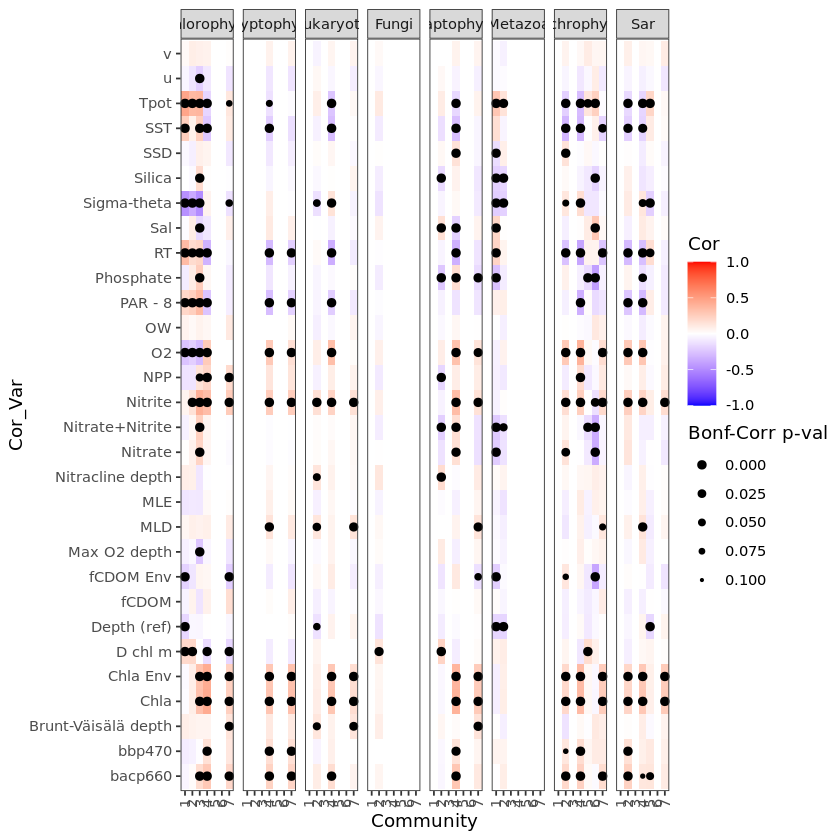

In [37]:
all_df = all_df %>% dplyr::mutate(Cor_Var = case_when(Cor_Var == 
                                             "PAR day [mol quanta/m**2/day] (for a period of 8 days around...)" ~ 
                             "PAR - 8",
                             Cor_Var == "MLD [m] (in the selected environmental...)" ~ 
                             "MLD",
                             Cor_Var == "u [cm/s] (Calculated (d'Ovidio et al. 2...)" ~ 
                             "u",
                             Cor_Var == "v [cm/s] (Calculated (d'Ovidio et al. 2...)" ~ "v",
                             Cor_Var == "fCDOM [ppb (QSE)] (at the sampling location, exp...)" ~ 
                             "fCDOM",
                             Cor_Var == "bbp470 [1/m] (in the selected environmental...)" ~ 
                             "bbp470",
                             Cor_Var == "bacp660 [1/m] (in the selected environmental...)" ~ 
                             "bacp660",
                             Cor_Var == "Sigma-theta [kg/m**3] (in the selected environmental...)" ~ 
                             "Sigma-theta",
                             Cor_Var == "fCDOM [ppb (QSE)] (in the selected environmental...)" ~ 
                             "fCDOM Env",
                             Cor_Var == "OW (indicates the presence of an ...)" ~ 
                             "OW",
                             Cor_Var == "Depth ref [m] (in the selected environmental...)" ~ 
                             "Depth (ref)",
                             Cor_Var == "Chl a [mg/m**3] (in the selected environmental...)" ~ 
                             "Chla Env",
                             Cor_Var == "Tpot [°C] (in the selected environmental...)" ~ "Tpot",
                             Cor_Var == "D chl m [m] (in the selected environmental...)" ~ "D chl m",  
                             Cor_Var == "Depth max Brunt Väisälä freq [m] (in the selected environmental...)" ~ 
                                             "Brunt-Väisälä depth",             
                             Cor_Var == "Depth max O2 [m] (in the selected environmental...)" ~ 
                                             "Max O2 depth",                 
                             #Cor_Var == "Depth min O2 [m] (in the selected environmental...)" ~ 
                             #                "Min O2 depth",               
                             Cor_Var == "Depth nitracline [m] (in the selected environmental...)" ~ 
                                             "Nitracline depth",        
                             Cor_Var == "MLE [1/day] (indicates the presence of a t...)" ~ "MLE",
                             Cor_Var == "SST grad h [°C/100 km] (Calculated (d'Ovidio et al. 2...)" ~ "SST",
                         TRUE ~ Cor_Var))

ggplot(all_df %>% dplyr::mutate(community = (as.character(community))) %>% 
        dplyr::mutate(Community = case_when(!is.na(community) ~ community,
                                            TRUE ~ "NoCommunity")) %>%
        dplyr::filter(Community != "NoCommunity")) + 
    geom_tile(aes(x=Community,y=Cor_Var,fill=Cor)) +
    geom_point(aes(x=Community,y=Cor_Var,size=Cor_Pval)) +
    scale_fill_gradient2(limits=c(-1,1),high = "red", low = "blue") +
    #scale_size_area(limits = c(0,0.1), breaks = c(0,0.049,0.1),
    #                labels=c("HighSig","Significant","MarginallySig"),
    #                name = "Bonf-Corr p-val") +
    scale_size(trans = 'reverse',limits=c(0.1,0),range=c(0.5,2),name = "Bonf-Corr p-val") +
    facet_wrap(~groups,nrow=1) +
    theme_test() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

**Community correlations based on only communities**

In [38]:
options(warn=-1)

all_df = data.frame()
for (var in vars_ofinterest) {
    current_df = metadata_melted %>%
        dplyr::left_join(combined_clust_info %>% 
                         dplyr::select(community,Cluster,MAG),#,HClustCluster),
                         by = c("old_mag_name" = "MAG")) %>%
        group_by(Station,community) %>% #groups
        dplyr::summarize(TPM = sum(TPM)) %>% 
        dplyr::left_join(ena_data,by=c("Station"="run_accession")) %>%
        dplyr::left_join(errnewdf %>% dplyr::mutate(ERR_list = trimws(ERR_list),
                                                    depth = as.numeric(as.character(depth)),
                                                    sf = as.numeric(as.character(sf))),
                                                    by=c("Station"="ERR_list")) %>%
        dplyr::filter(!is.na(!!as.symbol(var)) & !(is.na(TPM))) %>%
        group_by(community) %>% #groups
        dplyr::summarize(Cor=cor(!!as.symbol(var),TPM,use = "complete.obs",method="spearman"),
                         Cor_Pval=cor.test(!!as.symbol(var),TPM,method="spearman")$p.value) %>% 
        dplyr::mutate(community = (as.character(community))) %>%
        dplyr::mutate(Cor_Var = var)
    all_df = all_df %>% dplyr::bind_rows(current_df)
}
all_df$Cor_Pval = p.adjust(all_df$Cor_Pval, method = p.adjust.methods, n = length(all_df$Cor_Pval))
options(warn=0)

`summarise()` has grouped output by 'Station'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Station'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Station'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Station'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Station'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Station'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Station'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Station'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Station'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Station'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Station'. You

In [39]:
all_df = all_df %>% dplyr::mutate(Cor_Var = case_when(Cor_Var == 
                                             "PAR day [mol quanta/m**2/day] (for a period of 8 days around...)" ~ 
                             "PAR - 8",
                             Cor_Var == "MLD [m] (in the selected environmental...)" ~ 
                             "MLD",
                             Cor_Var == "u [cm/s] (Calculated (d'Ovidio et al. 2...)" ~ 
                             "u",
                             Cor_Var == "v [cm/s] (Calculated (d'Ovidio et al. 2...)" ~ "v",
                             Cor_Var == "fCDOM [ppb (QSE)] (at the sampling location, exp...)" ~ 
                             "fCDOM",
                             Cor_Var == "bbp470 [1/m] (in the selected environmental...)" ~ 
                             "bbp470",
                             Cor_Var == "bacp660 [1/m] (in the selected environmental...)" ~ 
                             "bacp660",
                             Cor_Var == "Sigma-theta [kg/m**3] (in the selected environmental...)" ~ 
                             "Sigma-theta",
                             Cor_Var == "fCDOM [ppb (QSE)] (in the selected environmental...)" ~ 
                             "fCDOM Env",
                             Cor_Var == "OW (indicates the presence of an ...)" ~ 
                             "OW",
                             Cor_Var == "Depth ref [m] (in the selected environmental...)" ~ 
                             "Depth (ref)",
                             Cor_Var == "Chl a [mg/m**3] (in the selected environmental...)" ~ 
                             "Chla Env",
                             Cor_Var == "Tpot [°C] (in the selected environmental...)" ~ "Tpot",
                             Cor_Var == "D chl m [m] (in the selected environmental...)" ~ "D chl m",  
                             Cor_Var == "Depth max Brunt Väisälä freq [m] (in the selected environmental...)" ~ 
                                             "Brunt-Väisälä depth",             
                             Cor_Var == "Depth max O2 [m] (in the selected environmental...)" ~ 
                                             "Max O2 depth",                 
                             #Cor_Var == "Depth min O2 [m] (in the selected environmental...)" ~ 
                             #                "Min O2 depth",               
                             Cor_Var == "Depth nitracline [m] (in the selected environmental...)" ~ 
                                             "Nitracline depth",        
                             Cor_Var == "MLE [1/day] (indicates the presence of a t...)" ~ "MLE",
                             Cor_Var == "SST grad h [°C/100 km] (Calculated (d'Ovidio et al. 2...)" ~ "SST",
                         TRUE ~ Cor_Var))

corr_comm_only = ggplot(all_df %>% dplyr::mutate(community = (as.character(community))) %>% 
        dplyr::mutate(Community = case_when(!is.na(community) ~ community,
                                            TRUE ~ "NoCommunity")) %>%
        dplyr::filter(Community != "NoCommunity")) + 
    geom_tile(aes(x=Community,y=Cor_Var,fill=Cor)) +
    geom_point(aes(x=Community,y=Cor_Var,size=Cor_Pval)) +
    scale_fill_gradient2(limits=c(-1,1),high = "red", low = "blue",name="Correlation") +
    scale_size(trans = 'reverse',limits=c(0.1,0),range=c(0.5,2),name = "Bonferroni\np-val") +
    theme_test() +
    ylab("") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [40]:
corr_df = all_df %>% pivot_wider(id_cols = community, names_from = Cor_Var, values_from = Cor) %>% 
    dplyr::filter(!is.na(community)) %>% column_to_rownames(var = "community")

In [41]:
community_station_data = metadata_melted %>%
        dplyr::left_join(combined_clust_info %>% 
                         dplyr::select(community,Cluster,MAG),#,HClustCluster),
                         by = c("old_mag_name" = "MAG")) %>%
        group_by(Station,community) %>% #groups
        dplyr::summarize(TPM = sum(TPM)) %>%
        dplyr::filter(!is.na(community))

corr_df = community_station_data %>% dplyr::filter(!is.na(community)) %>%
    pivot_wider(id_cols = Station, names_from = community, values_from = TPM) %>% 
    column_to_rownames(var = "Station")

`summarise()` has grouped output by 'Station'. You can override using the `.groups` argument.



In [42]:
cluster_dendro = as.dendrogram(hclust(dist(t(corr_df))))

In [43]:
environmental_station_data_byclust = metadata_melted %>%
        dplyr::left_join(combined_clust_info %>% 
                         dplyr::select(community,Cluster,MAG),#,HClustCluster),
                         by = c("old_mag_name" = "MAG")) %>%
        dplyr::left_join(ena_data,by=c("Station"="run_accession")) %>%
        dplyr::left_join(errnewdf %>% dplyr::mutate(ERR_list = trimws(ERR_list),
                                                    depth = as.numeric(as.character(depth)),
                                                    sf = as.numeric(as.character(sf))),
                                                    by=c("Station"="ERR_list")) %>%
        dplyr::filter(!is.na(TPM)) %>%
        group_by(Station) %>% #groups
        dplyr::summarize_if(is.numeric,sum) %>% 
        dplyr::select(c(vars_ofinterest,"Station")) %>%
        pivot_longer(names_to = "Cor_Var",values_to="TPM",cols=-c("Station"))
environmental_station_data_byclust = environmental_station_data_byclust %>% 
                             dplyr::mutate(Cor_Var = case_when(Cor_Var == 
                                             "PAR day [mol quanta/m**2/day] (for a period of 8 days around...)" ~ 
                             "PAR - 8",
                             Cor_Var == "MLD [m] (in the selected environmental...)" ~ 
                             "MLD",
                             Cor_Var == "u [cm/s] (Calculated (d'Ovidio et al. 2...)" ~ 
                             "u",
                             Cor_Var == "v [cm/s] (Calculated (d'Ovidio et al. 2...)" ~ "v",
                             Cor_Var == "fCDOM [ppb (QSE)] (at the sampling location, exp...)" ~ 
                             "fCDOM",
                             Cor_Var == "bbp470 [1/m] (in the selected environmental...)" ~ 
                             "bbp470",
                             Cor_Var == "bacp660 [1/m] (in the selected environmental...)" ~ 
                             "bacp660",
                             Cor_Var == "Sigma-theta [kg/m**3] (in the selected environmental...)" ~ 
                             "Sigma-theta",
                             Cor_Var == "fCDOM [ppb (QSE)] (in the selected environmental...)" ~ 
                             "fCDOM Env",
                             Cor_Var == "Chl a [mg/m**3] (in the selected environmental...)" ~ 
                             "Chla Env",
                             Cor_Var == "Depth ref [m] (in the selected environmental...)" ~ 
                             "Depth (ref)",
                             Cor_Var == "OW (indicates the presence of an ...)" ~ 
                             "OW",
                             Cor_Var == "Tpot [°C] (in the selected environmental...)" ~ "Tpot",
                             Cor_Var == "D chl m [m] (in the selected environmental...)" ~ "D chl m",  
                             Cor_Var == "Depth max Brunt Väisälä freq [m] (in the selected environmental...)" ~ 
                                             "Brunt-Väisälä depth",             
                             Cor_Var == "Depth max O2 [m] (in the selected environmental...)" ~ 
                                             "Max O2 depth",               
                             Cor_Var == "Depth nitracline [m] (in the selected environmental...)" ~ 
                                             "Nitracline depth",        
                             Cor_Var == "MLE [1/day] (indicates the presence of a t...)" ~ "MLE",
                             Cor_Var == "SST grad h [°C/100 km] (Calculated (d'Ovidio et al. 2...)" ~ "SST",
                         TRUE ~ Cor_Var)) %>%
                pivot_wider(id_cols = "Station", names_from = "Cor_Var", values_from = "TPM")
corr_df_env = environmental_station_data_byclust %>% column_to_rownames(var = "Station")

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(vars_ofinterest)` instead of `vars_ofinterest` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.



In [44]:
env_dendro = as.dendrogram(hclust(dist(t(corr_df_env))))

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Warning message:
“Removed 137 rows containing missing values (geom_point).”
Warning message:
“Removed 137 rows containing missing values (geom_point).”


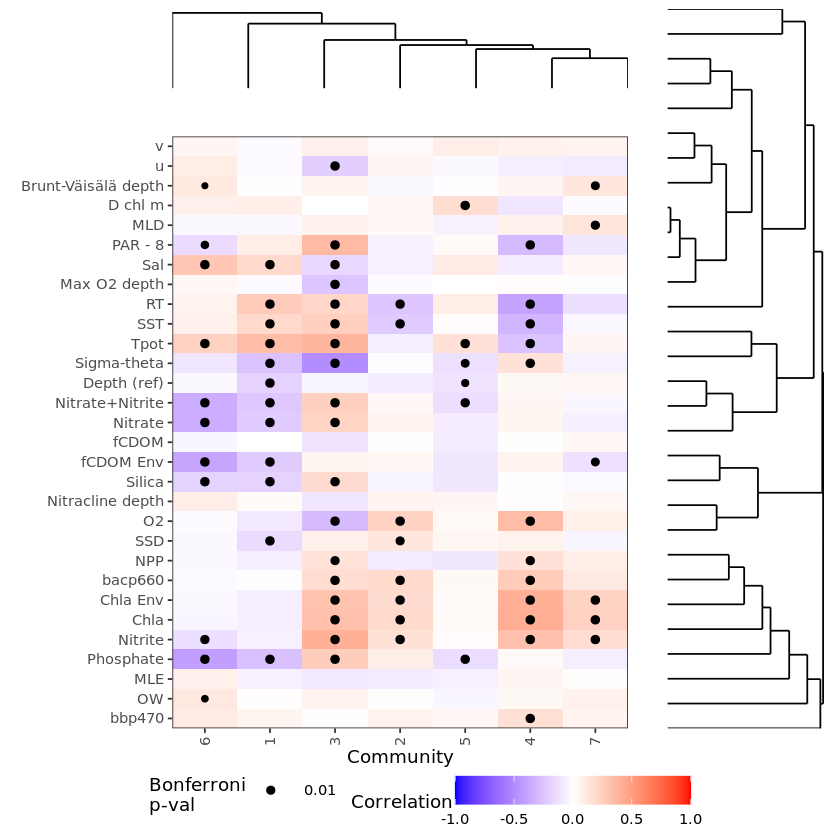

In [72]:
all_df_plot = all_df %>% dplyr::mutate(community = (as.character(community))) %>%
                        dplyr::mutate(Community = case_when(!is.na(community) ~ community,
                                            TRUE ~ "NoCommunity")) %>%
                        dplyr::filter(Community != "NoCommunity")

cluster_dendro = as.dendrogram(hclust(dist(t(corr_df),method="canberra")))
env_dendro = as.dendrogram(hclust(dist(t(corr_df_env),method="canberra")))
env.order <- order.dendrogram(env_dendro)

all_df_plot$Cor_Var_Ordered <- factor(x = all_df_plot$Cor_Var,
                               levels = colnames(corr_df_env)[env.order], 
                               ordered = TRUE)
all_df_plot$Cor_Var_Ordered <- match(all_df_plot$Cor_Var_Ordered,colnames(corr_df_env)[env.order])
comm.order <- order.dendrogram(cluster_dendro)

all_df_plot$Comm_Ordered <- factor(x = all_df_plot$community,
                               levels = colnames(corr_df)[comm.order], 
                               ordered = TRUE)
all_df_plot$Comm_Ordered <- match(all_df_plot$Comm_Ordered,colnames(corr_df)[comm.order])

dendro_env_labels = dendro_data(env_dendro, type = "rectangle")$labels
dendro_comm_labels = dendro_data(cluster_dendro, type = "rectangle")$labels

corr_comm_only = ggplot(all_df_plot) + 
    geom_tile(aes(x=Comm_Ordered,y=Cor_Var_Ordered,fill=Cor)) +
    geom_point(aes(x=Comm_Ordered,y=Cor_Var_Ordered,size=Cor_Pval)) +
    scale_fill_gradient2(limits=c(-1,1),high = "red", low = "blue",name="Correlation ") +
    scale_size(trans = 'reverse',limits=c(0.1,0),range=c(0.5,2),breaks=c(0.01),name = "Bonferroni \np-val") +
    theme_test() +
    scale_y_continuous(breaks = dendro_env_labels$x, 
        labels = dendro_env_labels$label,
        expand = c(0, 0)) + 
    scale_x_continuous(breaks = dendro_comm_labels$x, 
        labels = dendro_comm_labels$label,
        expand = c(0, 0)) + 
    ylab("") + xlab("Community") + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
          legend.position = "bottom")
dendro_gg_env = ggplot(segment(dendro_data(env_dendro, type = "rectangle"))) + 
  geom_segment(aes(x = x, y = y, xend = xend, yend = yend)) + 
  coord_flip() +
  #scale_y_reverse(expand = c(0.2, 0)) + 
  scale_x_reverse(expand = c(0.2, 0)) + xlim(c(1,30)) + 
  theme_dendro()

dendro_gg_env = ggplot(segment(dendro_data(env_dendro, type = "rectangle"))) + 
  geom_segment(aes(x = x, y = y, xend = xend, yend = yend)) + 
  coord_flip() +
  scale_x_reverse(expand = c(0.2, 0)) + xlim(c(1,30)) + 
  scale_x_continuous(breaks = dendro_env_labels$x, 
                       labels = dendro_env_labels$label,
                       expand = c(0, 0)) + theme_dendro()

dendro_gg_comm = ggplot(segment(dendro_data(cluster_dendro, type = "rectangle"))) + 
  geom_segment(aes(x = x, y = y, xend = xend, yend = yend)) + 
  #scale_y_reverse(expand = c(0.2, 0)) + 
  theme_dendro()

dendro_gg_comm_labels = dendro_data(cluster_dendro, type = "rectangle")$labels
dendro_gg_comm = ggplot(segment(dendro_data(cluster_dendro, type = "rectangle"))) + 
  geom_segment(aes(x = x, y = y, xend = xend, yend = yend)) +
  scale_x_continuous(breaks = dendro_gg_comm_labels$x, 
                       labels = dendro_gg_comm_labels$label,
                       expand = c(0, 0)) + theme_dendro()

corr_comm_only_dendro = cowplot::plot_grid(dendro_gg_comm,
                                           corr_comm_only + theme(plot.margin=grid::unit(c(-10,-5,-3,-3), "mm"),
                                                                  legend.position="none"), 
                                           rel_heights=c(0.2,1),rel_widths=c(0.3,1,0.3,1),
                                           ncol=1, align="hv",axis = "tblr")
#t, r, b, l  (trouble, top-right-bottom-left)
corr_comm_only_alldendro = cowplot::plot_grid(corr_comm_only_dendro + 
                                              theme(plot.margin=grid::unit(c(0,0,0,0), "mm")),
                                              dendro_gg_env, #+ 
                                              #theme(plot.margin=grid::unit(c(-8,0,-25,-10), "mm")), 
                   rel_widths=c(1,0.3),ncol=2,align = "v", axis = "tb")
corr_comm_only_alldendro = cowplot::plot_grid(corr_comm_only_alldendro,
                                              get_legend(corr_comm_only+
                                                         theme(legend.key.width=unit(1,"cm"))),
                                              ncol=1,rel_heights=c(1,0.1))
corr_comm_only_alldendro

Now we'll calculate some greaph metrics, in particular:
* Average correlation coefficient within-community
* number of >0.70 correlations between each community (measure of community similarity)
* within-community degree.

In [64]:
pacman::p_load(ggforce,ggnewscale)

In [65]:
layout_gr_broadclasses = layout_gr_classes %>%
    dplyr::mutate(groups_full = paste(Domain,Clade,Kingdom,Supergroup,Phylum,Class,sep=";")) %>%
    dplyr::mutate(groups = case_when(Kingdom == "Fungi" ~ "Fungi",
                                     grepl("Metazoa",groups_full) ~ "Metazoa",
                                     grepl("Chlorophyta",groups_full) ~ "Chlorophyta",
                                     grepl("Cryptophyta",groups_full) ~ "Cryptophyta",
                                     grepl("Cryptophyceae",groups_full) ~ "Cryptophyta",
                                     grepl("Haptophyta",groups_full) ~ "Haptophyta",
                                     grepl("Ochrophyta",groups_full) ~ "Ochrophyta",
                                     (groups_full == "Alveolata;Ciliophora") ~ "Sar",
                                     (groups_full == "Alveolata;Dinoflagellata") ~ "Sar",
                                     (groups_full == "Stramenopiles;-") ~ "Sar",
                                     (groups_full == "Stramenopiles;") ~ "Sar",
                                      grepl("Amoebozoa",groups_full)  ~ "Amoebozoa",
                                      grepl("Apusozoa",groups_full)  ~ "Apusozoa",
                                     ((Kingdom == ".") & (Clade == "Sar") & 
                                     (Phylum == ".") & (Class == ".")) ~ "Sar",
                                     (groups_full == "-;") ~ "Eukaryota",
                                     (groups_full == "-;-") ~ "Eukaryota",
                                     (groups_full == ";-") ~ "Eukaryota",
                                     (Clade == "Sar") ~ "Sar",
                                     TRUE ~ "Bacteria"))

color_groups = read.csv('/vortexfs1/omics/alexander/halexander/2020-tara-final-paper/data/taxonomy_color_ranges.csv', 
                   row.names=1) %>% dplyr::mutate(mags = rownames(.)) %>%
                   dplyr::rename("groups_full" = "name") %>%
                   dplyr::mutate(groups = case_when(grepl("Fungi",groups_full) ~ "Fungi",
                                     grepl("Metazoa",groups_full) ~ "Metazoa",
                                     grepl("Chlorophyta",groups_full) ~ "Chlorophyta",
                                     grepl("Cryptophyta",groups_full) ~ "Cryptophyta",
                                     grepl("Cryptophyceae",groups_full) ~ "Cryptophyta",
                                     grepl("Haptophyta",groups_full) ~ "Haptophyta",
                                     grepl("Ochrophyta",groups_full) ~ "Ochrophyta",
                                     (groups_full == "Alveolata;Ciliophora") ~ "Sar",
                                     (groups_full == "Alveolata;Dinoflagellata") ~ "Sar",
                                     (groups_full == "Stramenopiles;-") ~ "Sar",
                                     (groups_full == "Stramenopiles;") ~ "Sar",
                                      grepl("Amoebozoa",groups_full)  ~ "Amoebozoa",
                                      grepl("Apusozoa",groups_full)  ~ "Apusozoa",
                                     (grepl("SAR",groups_full) | 
                                      grepl("Stramenopiles",groups_full) | 
                                      grepl("Alveolata",groups_full)) ~ "Sar",
                                     (groups_full == "-;") ~ "Eukaryota",
                                     (groups_full == "-;-") ~ "Eukaryota",
                                     (groups_full == ";-") ~ "Eukaryota",
                                     grepl("Eukaryota",groups_full) ~ "Eukaryota",
                                     TRUE ~ "Bacteria"))

In [66]:
distinct_cols <- c("#4b9200","#98008d","#93d779","black","#ff55b0","#2a5e2b",
                   "#e195ff","#fb9113","#01acc8","#f12450","#7d6100",
                   "#793e69","#a54d00","#f2bb95")
community_cols = data.frame("community" = c(1:7), "commcolors" = distinct_cols[8:14])
layout_gr_broadclasses = layout_gr_broadclasses %>% 
    dplyr::left_join(color_groups %>% dplyr::select(color,groups), by = "groups") %>%
    dplyr::mutate(color = as.character(color)) %>%
    dplyr::mutate(community = as.numeric(community)) %>%
    dplyr::left_join(community_cols) %>%
    dplyr::mutate(commcolors = as.character(commcolors)) %>%
    dplyr::mutate(color = case_when((groups == "Bacteria") ~ "white",#commcolors,#"white",
                                    (groups == "Amoebozoa") ~ "yellow",
                                    (groups == "Apusozoa") ~ "#daa520",
                                    TRUE ~ color)) %>%
    dplyr::distinct()

Joining, by = "community"



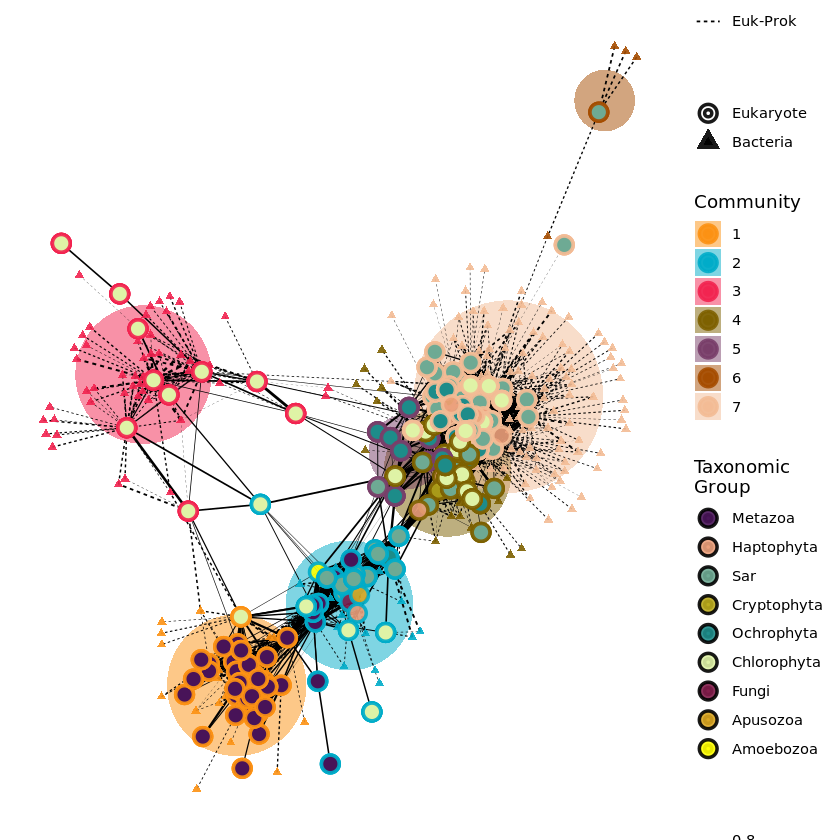

In [67]:
cluster_centers = layout_gr %>% dplyr::group_by(community) %>% 
                    dplyr::summarize(mean_x = mean(V1),mean_y=mean(V2),n_points=n())
distinct_cols <- c("#6068da","#50c150","#8f45b4","#acb833","#c273e5",
                   "#81b84c","#c84aa9","#428529","#e64586","#5cc799",
                   "#b53b6d","#5eae6c","#cc454d","#41bcb8","#d2522c",
                   "#48a8d7","#da9c31","#4a68b5","#96872b","#a792df",
                   "#686d2b","#88589b","#b1b268","#6e94d7","#9d5e2e",
                   "#d987c3","#377c53","#e18088","#dd9662","#9b4d68")
distinct_cols <- c("#4b9200","#98008d","#93d779","black","#ff55b0","#2a5e2b",
                   "#e195ff","#fb9113","#01acc8","#f12450","#7d6100",
                   "#793e69","#a54d00","#f2bb95")
network_plot = ggplot() +
    ggforce::geom_circle(data = cluster_centers, aes(x0 = mean_x, y0 = mean_y, r = (n_points)^(1/3),
                                                     fill = factor(community)), col = NA, alpha = 0.5) + 
    scale_fill_manual(name = "Community", values = distinct_cols[8:14]) + 
    geom_segment(data=edge_df,aes(x=from.x,xend = to.x,y=from.y,
                                  yend = to.y,size=corrcoef,lty=Link),colour="black") +
    new_scale_fill() + 
    geom_point(data=layout_gr_broadclasses %>% dplyr::filter(Domain != "Eukaryota"), #%>% 
               #dplyr::mutate(groups = case_when((is.na(Supergroup)) | (Supergroup == "NA") ~ "Bacteria",
               #                                     TRUE ~ Supergroup)),
               aes(x=V1,y=V2,shape=factor(eukprok),fill=factor(groups),color=factor(community)),
               alpha=0.9,stroke=1.5,size=1) +
    geom_point(data=layout_gr_broadclasses %>% dplyr::filter(Domain == "Eukaryota"),
               aes(x=V1,y=V2,shape=factor(eukprok),fill=factor(groups),color=factor(community)),
               alpha=0.9,stroke=1.5,size=4) +
    scale_fill_manual(name = "Taxonomic\nGroup", 
                      breaks = (layout_gr_broadclasses %>% dplyr::filter(groups!="Bacteria"))$groups, 
                      values = (layout_gr_broadclasses %>% dplyr::filter(groups!="Bacteria"))$color) + #values = distinct_cols[1:7]) + 
    scale_color_manual(name = "Community", values = distinct_cols[8:14]) + 
    guides(fill = guide_legend(override.aes = list("shape"=21))) + 
    theme_bw() +
    scale_shape_manual(name = "", values=c(21,17), breaks = c("euk","prok"), labels = c("Eukaryote","Bacteria")) + 
    scale_size(range = c(0, 1),labels=c("0.7","0.8","0.9"),breaks=c(0.7,0.8,0.9),name="") + 
    theme(
      axis.text.x = element_blank(),  # remove x-axis text
      axis.text.y = element_blank(), # remove y-axis text
      axis.ticks = element_blank(),  # remove axis ticks
      axis.title.x = element_blank(), # remove x-axis labels
      axis.title.y = element_blank(), # remove y-axis labels
      panel.background = element_blank(), 
      panel.border =element_blank(), 
      panel.grid.major = element_blank(),  #remove major-grid labels
      panel.grid.minor = element_blank(),  #remove minor-grid labels
      plot.background = element_blank())
network_plot
ggsave("network_plot.png",width=12,height=8,units="in")

In [68]:
reclustered_network_posneg = for_igraph_buscofilt_all %>% 
    dplyr::mutate("Classifications_from" = get_tax_string(for_igraph_buscofilt_all$from,cluster_groups)) %>%
    dplyr::mutate("Classifications_to" = get_tax_string(for_igraph_buscofilt_all$to,cluster_groups)) %>%
    separate(Classifications_to, sep = ";", fill = "left",
                    paste0(c("Domain","Clade","Kingdom","Supergroup","Phylum","Class",
                 "Order","Family","Genus","Species"),"_to")) %>%
    separate(Classifications_from, sep = ";", fill = "left",
                    paste0(c("Domain","Clade","Kingdom","Supergroup","Phylum","Class",
                 "Order","Family","Genus","Species"),"_from")) %>%
    dplyr::left_join(cluster_groups, by=c("from"="MAG")) %>%
    dplyr::rename(c("Cluster_From" = "Cluster")) %>%
    dplyr::left_join(cluster_groups, by=c("to"="MAG")) %>%
    dplyr::rename(c("Cluster_To" = "Cluster")) %>%  
    dplyr::mutate(from = case_when(grepl("Cluster", Cluster_From) ~ Cluster_From,
                                   TRUE ~ from)) %>%
    dplyr::mutate(to = case_when(grepl("Cluster", Cluster_To) ~ Cluster_To,
                                   TRUE ~ to)) %>%
    dplyr::filter(abs(corrcoef) > 0.7) %>%
    dplyr::filter(from != to) 
reclustered_network_posneg$Domain_to[is.na(reclustered_network_posneg$Domain_to)] = "Bacteria"
reclustered_network_posneg$Domain_from[is.na(reclustered_network_posneg$Domain_from)] = "Bacteria"

In [69]:
tracking_communities = reclustered_network_posneg %>% dplyr::left_join(layout_gr_broadclasses %>% #dplyr::select(mag,community,classification) %>%
                             dplyr::rename(c("community_to" = "community",
                                             "Domain_to" = "Domain",
                                             "Supergroup_to" = "Supergroup",
                                             "Group_to" = "groups",
                                             "Phylum_to" = "Phylum",
                                             "degree_to" = "degree")), by = c("to" = "mag")) %>%
            dplyr::left_join(layout_gr_broadclasses %>% #dplyr::select(mag,community,classification) %>%
                             dplyr::rename(c("community_from" = "community",
                                             "Domain_from" = "Domain",
                                             "Supergroup_from" = "Supergroup",
                                             "Group_from" = "groups",
                                             "Phylum_from" = "Phylum",
                                             "degree_from" = "degree")), by = c("from" = "mag")) %>%
            dplyr::distinct(.keep_all=TRUE)

In [70]:
options(repr.matrix.max.cols=150, repr.matrix.max.rows=200)

head(tracking_communities)

,X,to,from,corrcoef,Link,Dom1,Dom2,Completeness.x,Contamination.x,Completeness.y,Contamination.y,Domain_from.x,Clade_from,Kingdom_from,Supergroup_from.x,Phylum_from.x,Class_from,Order_from,Family_from,Genus_from,Species_from,Domain_to.x,Clade_to,Kingdom_to,Supergroup_to.x,Phylum_to.x,Class_to,Order_to,Family_to,Genus_to,Species_to,Cluster_From,classification.x,Cluster_To,classification.y,V1.x,V2.x,eukprok.x,Domain_to.y,Clade.x,Kingdom.x,Supergroup_to.y,Phylum_to.y,Class.x,Order.x,Family.x,Genus.x,Species.x,community_to,degree_to,groups_full.x,Group_to,color.x,commcolors.x,V1.y,V2.y,eukprok.y,Domain_from.y,Clade.y,Kingdom.y,Supergroup_from.y,Phylum_from.y,Class.y,Order.y,Family.y,Genus.y,Species.y,community_from,degree_from,groups_full.y,Group_from,color.y,commcolors.y
,<int>,<chr>,<chr>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,9,Cluster_3,Cluster_1,0.7061998,Euk-Euk,euk,euk,57.64706,1.176471,62.7451,0.3921569,Eukaryota,Opisthokonta,Metazoa,Metazoa,Arthropoda,Hexanauplia,Calanoida,Temoridae,Eurytemora,Eurytemora affinis,Eukaryota,Opisthokonta,Metazoa,Metazoa,Arthropoda,Hexanauplia,Harpacticoida,Harpacticidae,Tigriopus,Tigriopus californicus,Cluster_1,Eukaryota;Opisthokonta;Metazoa;Metazoa;Arthropoda;Hexanauplia;Calanoida;Temoridae;Eurytemora;Eurytemora affinis,Cluster_3,Eukaryota;Opisthokonta;Metazoa;Metazoa;Arthropoda;Hexanauplia;Harpacticoida;Harpacticidae;Tigriopus;Tigriopus californicus,-5.08735,-10.31205,euk,Eukaryota,Opisthokonta,Metazoa,Metazoa,Arthropoda,Hexanauplia,Harpacticoida,Harpacticidae,Tigriopus,Tigriopus californicus,1,37,Eukaryota;Opisthokonta;Metazoa;Metazoa;Arthropoda;Hexanauplia,Metazoa,#481358,#fb9113,-3.989345,-10.73205,euk,Eukaryota,Opisthokonta,Metazoa,Metazoa,Arthropoda,Hexanauplia,Calanoida,Temoridae,Eurytemora,Eurytemora affinis,1,29,Eukaryota;Opisthokonta;Metazoa;Metazoa;Arthropoda;Hexanauplia,Metazoa,#481358,#fb9113
2,9,Cluster_3,Cluster_1,0.7061998,Euk-Euk,euk,euk,57.64706,1.176471,62.7451,0.3921569,Eukaryota,Opisthokonta,Metazoa,Metazoa,Arthropoda,Hexanauplia,Calanoida,Temoridae,Eurytemora,Eurytemora affinis,Eukaryota,Opisthokonta,Metazoa,Metazoa,Arthropoda,Hexanauplia,Harpacticoida,Harpacticidae,Tigriopus,Tigriopus californicus,Cluster_1,Eukaryota;Opisthokonta;Metazoa;Metazoa;Arthropoda;Hexanauplia;Calanoida;Temoridae;Eurytemora;Eurytemora affinis,Cluster_3,Eukaryota;Opisthokonta;Metazoa;Metazoa;Arthropoda;Hexanauplia;Harpacticoida;Harpacticidae;Tigriopus;Tigriopus californicus,-5.08735,-10.31205,euk,Eukaryota,Opisthokonta,Metazoa,Metazoa,Arthropoda,Hexanauplia,Harpacticoida,Harpacticidae,Tigriopus,Tigriopus californicus,1,37,Eukaryota;Opisthokonta;Metazoa;Metazoa;Arthropoda;Hexanauplia,Metazoa,#481358,#fb9113,-3.989345,-10.73205,euk,Eukaryota,Opisthokonta,Metazoa,Metazoa,Arthropoda,Hexanauplia,Calanoida,Temoridae,Eurytemora,Eurytemora affinis,1,29,Eukaryota;Opisthokonta;Metazoa;Metazoa;Arthropoda;Hexanauplia,Metazoa,#2F0D3B,#fb9113
3,9,Cluster_3,Cluster_1,0.7061998,Euk-Euk,euk,euk,57.64706,1.176471,62.7451,0.3921569,Eukaryota,Opisthokonta,Metazoa,Metazoa,Arthropoda,Hexanauplia,Calanoida,Temoridae,Eurytemora,Eurytemora affinis,Eukaryota,Opisthokonta,Metazoa,Metazoa,Arthropoda,Hexanauplia,Harpacticoida,Harpacticidae,Tigriopus,Tigriopus californicus,Cluster_1,Eukaryota;Opisthokonta;Metazoa;Metazoa;Arthropoda;Hexanauplia;Calanoida;Temoridae;Eurytemora;Eurytemora affinis,Cluster_3,Eukaryota;Opisthokonta;Metazoa;Metazoa;Arthropoda;Hexanauplia;Harpacticoida;Harpacticidae;Tigriopus;Tigriopus californicus,-5.08735,-10.31205,euk,Eukaryota,Opisthokonta,Metazoa,Metazoa,Arthropoda,Hexanauplia,Harpacticoida,Harpacticidae,Tigriopus,Tig

In [52]:
total_communities = layout_gr_broadclasses %>% dplyr::distinct(mag,.keep_all=TRUE) %>% 
    dplyr::group_by(community) %>% dplyr::tally()

In [53]:
total_communities_supergroup = layout_gr_broadclasses %>% dplyr::distinct(mag,.keep_all=TRUE) %>% 
    dplyr::group_by(community,groups,color) %>% 
    dplyr::mutate(groups = case_when(groups == "NA" ~ "Bacteria",
                                         TRUE ~ groups)) %>% dplyr::tally()

In [54]:
total_comm_bar = ggplot(total_communities_supergroup) + geom_bar(aes(x = community, y = n, fill = groups),
                                            position = "fill", stat = "identity",color="black") + coord_flip() + 
    theme_test() + ylab("Community") + xlab("Share of community") + 
    scale_fill_manual(name = "Taxonomic\ngroup", breaks = total_communities_supergroup$groups,
                      values = total_communities_supergroup$color)

In [55]:
# We want to divide the number of connections actually observed between each community to 
# the total possible between two communities, which is the size of the two communities
# multiplied together.
get_combo <- function(df_graph) { 
    combined_clust = c()
    for (i in c(1:length(df_graph$from))) {
        combined_clust = c(combined_clust,paste(sort(c(df_graph$from[i],df_graph$to[i])),collapse="_"))
    }
    return(combined_clust)
}
tracking_communities = tracking_communities %>% 
    dplyr::arrange(desc(corrcoef)) %>%
    dplyr::distinct(to,from,.keep_all=TRUE) %>%
    dplyr::filter(Link != "Other")
tracking_communities$comboclust = get_combo(tracking_communities)
tracking_communities = tracking_communities %>% 
    dplyr::arrange(desc(corrcoef)) %>%
    dplyr::distinct(comboclust,.keep_all=TRUE)
summarized_connections = tracking_communities %>% 
    dplyr::filter(!is.na(community_to) & !is.na(community_from)) %>%
    dplyr::group_by(community_to,community_from) %>% 
    dplyr::summarize(corrcoefmean = mean(corrcoef),number_connections=n()) %>%
    dplyr::left_join(total_communities %>% dplyr::rename("size_to"="n"),by = c("community_to"="community")) %>%
    dplyr::left_join(total_communities %>% dplyr::rename("size_from"="n"),by = c("community_from"="community")) %>%
    dplyr::mutate(possible_between = size_to * size_from)

`summarise()` has grouped output by 'community_to'. You can override using the `.groups` argument.



In [56]:
# Make a dataframe for each "from" link documenting the number of communities
# it is linked to
df1 = tracking_communities %>% 
    dplyr::filter(!is.na(community_to) & !is.na(community_from)) %>%
    dplyr::distinct(from,community_to,.keep_all=T) %>%
    dplyr::rename("candidate"="from")

# Make a dataframe for each "to" link documenting the number of communities
# it is linked to
df2 = tracking_communities %>% 
    dplyr::filter(!is.na(community_to) & !is.na(community_from)) %>%
    dplyr::distinct(to,community_from,.keep_all=T) %>%
    dplyr::rename("candidate"="to")

# combine the two DataFrames to account for each community member's level of
# inter-community engagement without duplications
tester = df1 %>% dplyr::bind_rows(df2) %>% 
    dplyr::distinct(candidate,community_to,community_from,.keep_all=T) %>% 
    dplyr::group_by(community_to,community_from) %>% 
    # tally up the total number of other communities each candidate engages with.
    dplyr::tally()

In [57]:
total_communities = layout_gr_classes %>% 
    dplyr::group_by(community) %>% dplyr::tally() %>%
    dplyr::mutate(community = as.integer(community))

df1 = tracking_communities %>% 
    dplyr::filter(!is.na(community_to) & !is.na(community_from)) %>%
    dplyr::distinct(from,community_to,.keep_all=T) %>%
    dplyr::rename("candidate"="from")

df2 = tracking_communities %>% 
    dplyr::filter(!is.na(community_to) & !is.na(community_from)) %>%
    dplyr::distinct(to,community_from,.keep_all=T) %>%
    dplyr::rename("candidate"="to")
tester = df1 %>% dplyr::bind_rows(df2) %>% 
    dplyr::distinct(candidate,community_to,community_from,.keep_all=T) %>% 
    dplyr::group_by(community_to,community_from) %>% 
    dplyr::tally() %>%
    dplyr::rename("number_connections" = "n")

summarized_connections = tracking_communities %>% 
    dplyr::filter(!is.na(community_to) & !is.na(community_from)) %>%
    dplyr::group_by(community_to,community_from) %>% 
    dplyr::summarize(corrcoefmean = mean(corrcoef),dense_connections=n()) %>%
    dplyr::left_join(tester,by=c("community_to","community_from")) %>%
    dplyr::mutate(number_connections = case_when(community_to==community_from ~ dense_connections,
                                                 TRUE ~ number_connections)) %>%
    dplyr::left_join(total_communities %>% dplyr::rename("size_to"="n"),by = c("community_to"="community")) %>%
    dplyr::left_join(total_communities %>% dplyr::rename("size_from"="n"),by = c("community_from"="community")) %>%
    dplyr::mutate(possible_between = max(size_to,size_from)) %>%# * size_from) %>%
    dplyr::mutate(possible_between = case_when(community_to==community_from ~ 
                                               as.integer((as.integer(size_to) * (as.integer(size_to) - 1)) / 2),
                                               #as.integer(lapply(lapply(size_to,as.integer),choose,2)),
                                               TRUE ~ possible_between))

`summarise()` has grouped output by 'community_to'. You can override using the `.groups` argument.



In [58]:
write.csv(summarized_connections,"summarized_connections.csv")

In [59]:
degree_strength = ggplot(summarized_connections) + 
    geom_tile(aes(x = factor(community_to), y = factor(community_from), 
                  fill = number_connections/possible_between)) + 
    geom_point(aes(x = factor(community_to), y = factor(community_from), 
                  size = corrcoefmean)) + 
    theme_test() + 
    ylab("Community 2") + xlab("Community 1") + 
    scale_fill_gradientn(colors=c("white","gold","orange","red"),limits=c(0,1),name="Connectedness") + 
    scale_size(name = "Mean correlation\ncoefficient")

In [60]:
degree_strength_legend = get_legend(degree_strength +
    theme(legend.position="bottom"))
total_all = total_communities_supergroup %>% dplyr::group_by(community) %>% dplyr::summarize(n_tot = sum(n))
total_comm_bar = total_comm_bar + geom_text(data = total_all, 
                                            aes(y=0.8,label=paste0("n=",n_tot),x=community),size=6)
grid_degree = cowplot::plot_grid(degree_strength + theme(legend.position = "none"),
                   total_comm_bar + theme(axis.text.y = element_blank(),
                                    axis.ticks.y = element_blank(),
                                    axis.title.y = element_blank() )+ 
                   ylab("Share of total community"), align = "bt", rel_widths=c(0.75,1))
degree_strength = cowplot::plot_grid(grid_degree,degree_strength_legend,ncol=1,rel_heights=c(1,0.25))

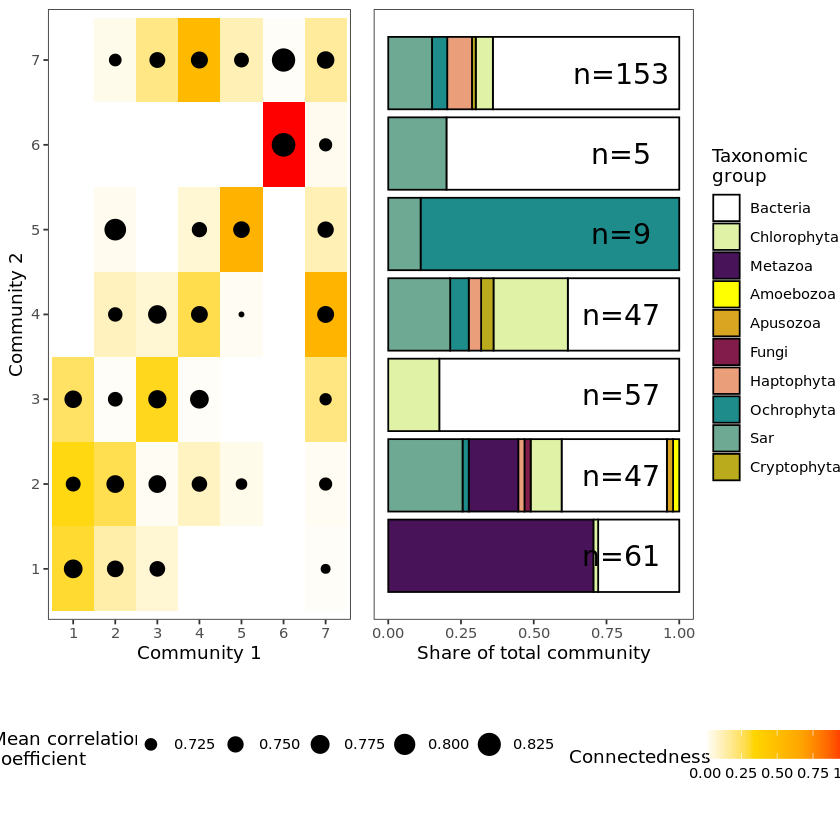

In [101]:
degree_strength

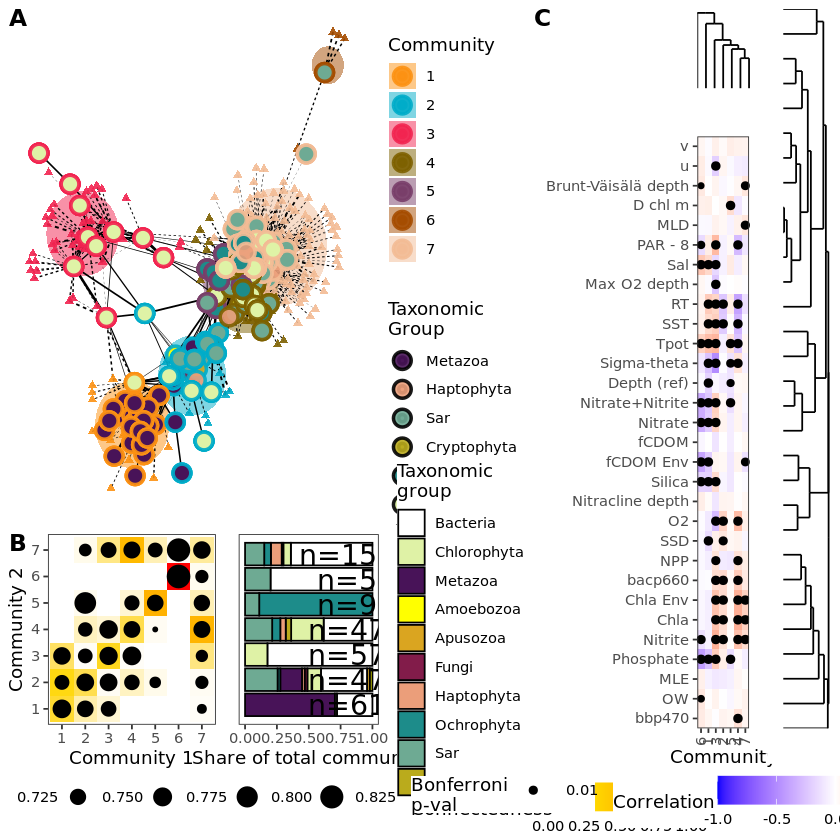

In [75]:
grid1 = cowplot::plot_grid(network_plot,degree_strength,nrow=2,rel_heights=c(1,0.6),labels=c("A","B"))
grid2 = cowplot::plot_grid(grid1,corr_comm_only_alldendro,nrow=1,rel_widths=c(1,0.6),labels=c("","C")) #,rel_heights=c(1,0.5))
grid2 
ggsave(file.path("..","figures","fig5_alexander_2021.png"),width=17,height=13,units="in",dpi=400)

In [ ]:
grid2